In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import astropy
import os
import pandas as pd
import xlsxwriter
import matplotlib as mpl
import matplotlib.image as mpimg

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astronomaly.base.base_pipeline import PipelineStage
from astronomaly.base import logging_tools

In [2]:
def image_transform_sigma_clipping(img, sigma=3, central=True):
    """
    Applies sigma clipping, fits contours and

    Parameters
    ----------
    img : np.ndarray
        Input image

    Returns
    -------
    np.ndarray

    """
    if len(img.shape) > 2:
        im = img[:, :, 0]
    else:
        im = img

    im = np.nan_to_num(im)  # OpenCV can't handle NaNs

    mean, median, std = sigma_clipped_stats(im, sigma=sigma)
    thresh = std + median
    img_bin = np.zeros(im.shape, dtype=np.uint8)

    img_bin[im <= thresh] = 0
    img_bin[im > thresh] = 1

    contours, hierarchy = cv2.findContours(img_bin, 
                                           cv2.RETR_EXTERNAL, 
                                           cv2.CHAIN_APPROX_SIMPLE)

    x0 = img.shape[0] // 2
    y0 = img.shape[1] // 2

    for c in contours:
        if cv2.pointPolygonTest(c, (x0, y0), False) == 1:
            break

    contour_mask = np.zeros_like(img, dtype=np.uint8)
    if len(contours) == 0:
        # This happens if there's no data in the image so we just return zeros
        return contour_mask
    cv2.drawContours(contour_mask, [c], 0, (1, 1, 1), -1)

    new_img = np.zeros_like(img)
    new_img[contour_mask == 1] = img[contour_mask == 1]

    return new_img

In [3]:
def image_transform_scale(img):
    """
    Small function to normalise an image between 0 and 1. Useful for deep 
    learning.

    Parameters
    ----------
    img : np.ndarray
        Input image

    Returns
    -------
    np.ndarray
        Scaled image

    """
    if img.min() == img.max():
        return img
    return (img - img.min()) / (img.max() - img.min())

In [4]:
def find_contours(img, threshold):
    """
    Finds the contours of an image that meet a threshold

    Parameters
    ----------
    img : np.ndarray
        Input image (must be greyscale)
    threshold : float
        What threshold to use

    Returns
    -------
    contours
        opencv description of contours (each contour is a list of x,y values
        and there may be several contours, given as a list of lists)
    hierarchy
        opencv description of how contours relate to each other (see opencv 
        documentation)
    """

    img_bin = np.zeros(img.shape, dtype=np.uint8)

    img_bin[img <= threshold] = 0
    img_bin[img > threshold] = 1

    contours,hierarchy = cv2.findContours(img_bin,
                            cv2.RETR_EXTERNAL, 
                            cv2.CHAIN_APPROX_SIMPLE)

    return contours, hierarchy

In [5]:
def draw_contour(contour, image, filled=False):
    """
    Draws a contour onto an image for diagnostic purposes

    Parameters
    ----------
    contour : np.ndarray
        Array of x,y values describing the contours (as returned by opencv's
        findCountours function)
    image : np.ndarray
        The original image the contour was fit to.
    filled : bool, optional
        If true will fill in the contour otherwise will return an outline.
    Returns
    -------
    np.ndarray
        The image with the drawn contour on top
    """

    if filled:
        thickness = -1
        contour_arr = np.zeros([image.shape[0], image.shape[1]])
    else:
        thickness = 1
        contour_arr = image.copy()
    
    
    # This part determines which contour to draw. Also the difficult part since drawing all causes the ellipses
    # to fail. Will need to obtain the largest contour either HERE or before drawing the ellipse! 
    # (-1 is all contours)
    
    cv2.drawContours(contour_arr, [contour], 0, (1, 1, 1), thickness)
    
    print(np.shape(contour))
    
    return contour_arr

In [6]:
def fit_ellipse(contour, image, return_params=False):
    """
    Fits an ellipse to a contour and returns a binary image representation of
    the ellipse.

    Parameters
    ----------
    contour : np.ndarray
        Array of x,y values describing the contours (as returned by opencv's
        findCountours function)
    image : np.ndarray
        The original image the contour was fit to.
    return_params : bool
        If true also returns the parameters of the fitted ellipse

    Returns
    -------
    np.ndarray
        2d binary image with representation of the ellipse
    """

    thickness = 2
    y_npix = image.shape[0]
    x_npix = image.shape[1]
    ellipse_arr = np.zeros([y_npix, x_npix], dtype=np.float)

    # Sets some defaults for when the fitting fails
    default_return_params = [np.nan] * 5 
    raised_error = False

    try:
        ((x0, y0), (maj_axis, min_axis), theta) = cv2.fitEllipse(contour)
        ellipse_params = x0, y0, maj_axis, min_axis, theta

        if np.any(np.isnan(ellipse_params)):
            raised_error = True
            logging_tools.log('fit_ellipse failed with unknown error:')

    except cv2.error as e:
        logging_tools.log('fit_ellipse failed with cv2 error:' + e.msg)
        raised_error = True

    if raised_error:
        if return_params:
            return ellipse_arr, default_return_params
        else:
            return ellipse_arr

    x0 = int(np.round(x0))
    y0 = int(np.round(y0))
    maj_axis = int(np.round(maj_axis))
    min_axis = int(np.round(min_axis))
    theta = int(np.round(theta))

    cv2.ellipse(ellipse_arr, (x0, y0), (maj_axis // 2, min_axis // 2), 
                theta, 0, 360, (1, 1, 1), thickness)

    if return_params:
        return ellipse_arr, ellipse_params
    else:
        return ellipse_arr

In [7]:
def get_ellipse_leastsq(contour, image):
    """
    Fits an ellipse to a (single) contour and returns the sum of the
    differences squared between the fitted ellipse and contour (normalised).

    Parameters
    ----------
    contour : np.ndarray
        Array of x,y values describing the contours (as returned by opencv's
        findCountours function)
    image : np.ndarray
        The original image the contour was fit to.

    Returns
    -------
    float
        sum((ellipse-contour)^2)/number_of_pixels
    """
    thickness = -1
    y_npix = image.shape[0]
    x_npix = image.shape[1]

    contour_arr = np.zeros([y_npix, x_npix], dtype=np.float)
    cv2.drawContours(contour_arr, [contour], 0, (1, 1, 1), thickness)

    ellipse_arr, params = fit_ellipse(contour, image, return_params=True)

    if np.any(np.isnan(params)):
        res = np.nan
    else:
        arr_diff = ellipse_arr - contour_arr
        res = np.sum((arr_diff)**2) / np.prod(contour_arr.shape)

    return [res] + list(params)

# Loading the images

## Read in image data

In [8]:
good_image = '/home/verlon/Desktop/Astronomaly/Data/Input/Good Images/cutout_23.3816_-6.8632.fits'

good_image_data = fits.getdata(good_image)

### Run Sigma Clipping on Images

In [9]:
clipped_good_image_g = image_transform_scale(image_transform_sigma_clipping(good_image_data[0], sigma=3, central=True))
clipped_good_image_r = image_transform_scale(image_transform_sigma_clipping(good_image_data[1], sigma=3, central=True))
clipped_good_image_z = image_transform_scale(image_transform_sigma_clipping(good_image_data[2], sigma=3, central=True))

In [10]:
clipped_good_image_g

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Overlap the bands

In [11]:
overlapped_good_image = np.add(good_image_data[0],good_image_data[1],good_image_data[2])

clipped_overlapped_good_image = image_transform_scale(image_transform_sigma_clipping(overlapped_good_image, sigma=3, central=True))

## Read in image data

In [12]:
bad_image = '/home/verlon/Desktop/Astronomaly/Data/Input/Bad Images/cutout_23.7486_-6.3234.fits'

bad_image_data = fits.getdata(bad_image)

### Run Sigma Clipping on Images

In [13]:
clipped_bad_image_g = image_transform_scale(image_transform_sigma_clipping(bad_image_data[0], sigma=3, central=True))
clipped_bad_image_r = image_transform_scale(image_transform_sigma_clipping(bad_image_data[1], sigma=3, central=True))
clipped_bad_image_z = image_transform_scale(image_transform_sigma_clipping(bad_image_data[2], sigma=3, central=True))

### Overlap the bands

In [14]:
overlapped_bad_image = np.add(bad_image_data[0],bad_image_data[1],bad_image_data[2])

clipped_overlapped_bad_image = image_transform_scale(image_transform_sigma_clipping(overlapped_bad_image, sigma=3, central=True))

# Image and Percentiles

In [15]:
image = clipped_bad_image_r

In [16]:
percentiles = [90,80,70,60,50,0]

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


## Adjusted Function

In [17]:
def contours_and_ellipses(image, percentiles):
    
    image_ = image
    
    #this_image = image_transform_scale(image)
    #image = image_transform_sigma_clipping(this_image, sigma=3, central=True)
    
    
    this_image = image_transform_sigma_clipping(image, sigma=3, central=True)
    #image = this_image
    image = image_transform_scale(this_image)
    
    x0 = y0 = -1
    x_cent = image.shape[0] // 2
    y_cent = image.shape[1] // 2
    
    feats = []
    # Start with the closest in contour (highest percentile)
    percentiles = np.sort(percentiles)[::-1] 

    if np.all(image == 0):
        failed = True
        failure_message = "Invalid cutout for feature extraction"
    else:
        failed = False
        failure_message = ""

    for p in percentiles:
        if failed:
            contours = []
        else:
            thresh = np.percentile(image[image > 0], p)
            contours, hierarchy = find_contours(image, thresh)

            x_contours = np.zeros(len(contours))
            y_contours = np.zeros(len(contours))
        
            if len(contours[0]) != 0:
                for k in range(len(contours)):
                    M = cv2.moments(contours[k])
                    try:
                        x_contours[k] = int(M["m10"] / M["m00"])
                        y_contours[k] = int(M["m01"] / M["m00"])
                    except ZeroDivisionError:
                        pass
                if x0 == -1:
                    x_diff = x_contours - x_cent
                    y_diff = y_contours - y_cent
                else:
                    x_diff = x_contours - x0
                    y_diff = y_contours - y0
                
                # Will try to find the CLOSEST contour to the central one
                r_diff = np.sqrt(x_diff**2 + y_diff**2)

                ind = np.argmin(r_diff)

                if x0 == -1:
                    x0 = x_contours[ind]
                    y0 = y_contours[ind]

                c = contours[ind]
                
           ######### Added ALL of this to test for differences
        
                params = get_ellipse_leastsq(c, image)
                # Params return in this order:
                # residual, x0, y0, maj_axis, min_axis, theta
                if np.any(np.isnan(params)):
                    failed = True
                else:
                    if params[3] == 0 or params[4] == 0:
                        aspect = 1
                    else:
                        aspect = params[4] / params[3]

                    if aspect < 1:
                        aspect = 1 / aspect
                    if aspect > 100:
                        aspect = 1                
                
                    new_params = params[:3] + [aspect] + [params[-1]]
                    feats.append(new_params)
            else:
                failed = True
                failure_message = "No contour found"

            if failed:
                feats.append([np.nan] * 5)
                logging_tools.log(failure_message)
            
        # Now we have the leastsq value, x0, y0, aspect_ratio, theta for each 
        # sigma
        # Normalise things relative to the highest threshold value
        # If there were problems with any sigma levels, set all values to NaNs
        if np.any(np.isnan(feats)):
            return [np.nan] * 4 * len(percentiles)
        else:
            max_ind = np.argmax(percentiles)

            residuals = []
            dist_to_centre = []
            aspect = []
            theta = []

            x0_max_sigma = feats[max_ind][1]
            y0_max_sigma = feats[max_ind][2]
            aspect_max_sigma = feats[max_ind][3]
            theta_max_sigma = feats[max_ind][4]

            for n in range(len(feats)):
                prms = feats[n]
                residuals.append(prms[0])
                if prms[1] == 0 or prms[2] == 0:
                    r = 0
                else:
                    x_diff = prms[1] - x0_max_sigma
                    y_diff = prms[2] - y0_max_sigma
                    r = np.sqrt((x_diff)**2 + (y_diff)**2)
                dist_to_centre.append(r)
                aspect.append(prms[3] / aspect_max_sigma)
                theta_diff = np.abs(prms[4] - theta_max_sigma) % 360
                # Because there's redundancy about which way an ellipse 
                # is aligned, we always take the acute angle
                if theta_diff > 90:
                    theta_diff -= 90
                theta.append(theta_diff)

            normalized_parameters = np.hstack((residuals, dist_to_centre, aspect, theta))
            
            #########
            
        thickness = 2
            
        y_npix = image.shape[0]
        x_npix = image.shape[1]
            
        contour_arr = np.zeros([y_npix, x_npix], dtype=np.float)
            
        arr = image.copy()
            
        cnt = cv2.drawContours(arr, [c], 0, (0.5, 0, 0), thickness)
            
        ellipse_arr, params = fit_ellipse(c, image, return_params=True)

            #print('Percentile is :' ,p)
            #print( 'Parameters are :' ,params)
        print(normalized_parameters)
            
            # Display the contours and ellipses
        f = plt.figure(figsize = (20,15))
        
        f.add_subplot(1,5, 1)
        plt.title('Original', fontsize = 14)
        plt.imshow(image_, cmap='hot')
        
        f.add_subplot(1,5, 2)
        plt.title('Sigma Clipped', fontsize = 14)
        plt.imshow(this_image, cmap='hot')  
        
        f.add_subplot(1,5, 3)
        plt.title('Normalised', fontsize = 14)
        plt.imshow(image, cmap='hot')        
        
        f.add_subplot(1,5, 4)
        plt.title('Last Contour', fontsize = 14)
        plt.imshow(cnt, cmap='hot')

        f.add_subplot(1,5, 5)
        plt.title('Last Ellipse', fontsize = 14)
        plt.imshow(ellipse_arr, cmap='hot')
            
        plt.show(block=True)

[0.03219604 0.         1.         0.        ]


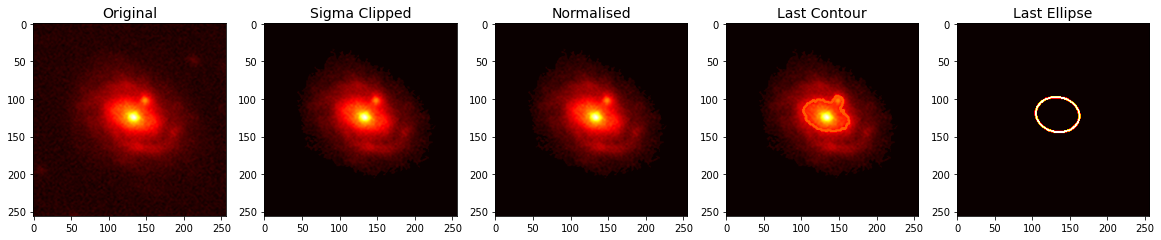

[ 0.03219604  0.06323242  0.          3.07240816  1.          0.90333021
  0.         23.06352997]


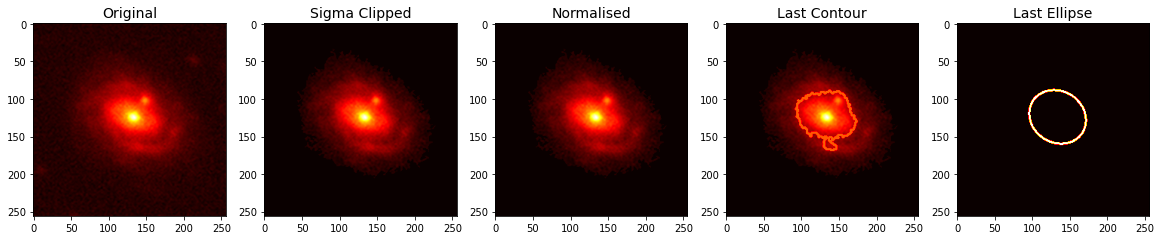

[3.21960449e-02 6.32324219e-02 9.03472900e-02 0.00000000e+00
 3.07240816e+00 3.92726039e+00 1.00000000e+00 9.03330214e-01
 1.03165149e+00 0.00000000e+00 2.30635300e+01 4.31844177e+01]


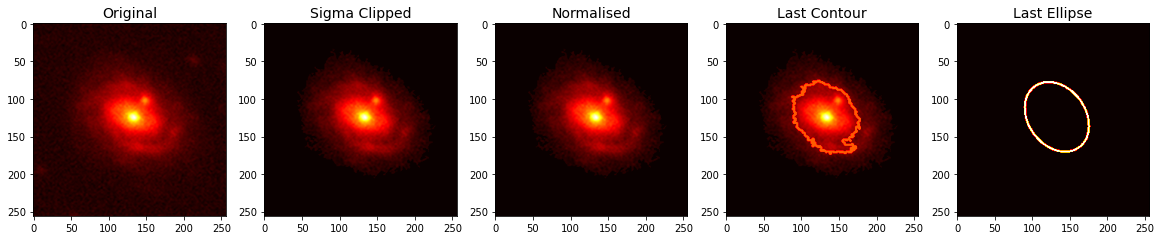

[3.21960449e-02 6.32324219e-02 9.03472900e-02 1.24114990e-01
 0.00000000e+00 3.07240816e+00 3.92726039e+00 4.76073912e+00
 1.00000000e+00 9.03330214e-01 1.03165149e+00 1.12623744e+00
 0.00000000e+00 2.30635300e+01 4.31844177e+01 2.98370514e+01]


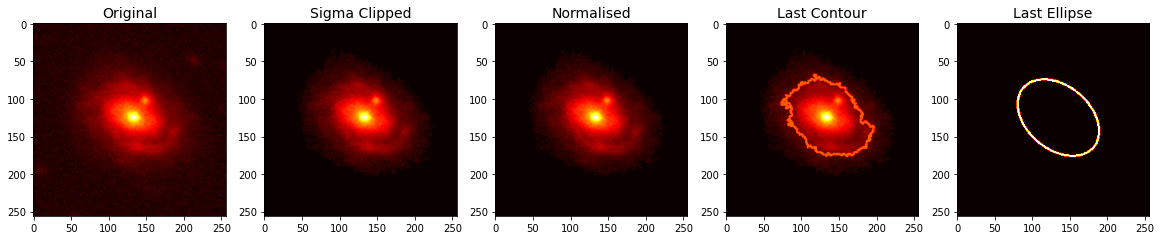

[3.21960449e-02 6.32324219e-02 9.03472900e-02 1.24114990e-01
 1.57165527e-01 0.00000000e+00 3.07240816e+00 3.92726039e+00
 4.76073912e+00 5.25005184e+00 1.00000000e+00 9.03330214e-01
 1.03165149e+00 1.12623744e+00 1.06383999e+00 0.00000000e+00
 2.30635300e+01 4.31844177e+01 2.98370514e+01 2.19152451e+01]


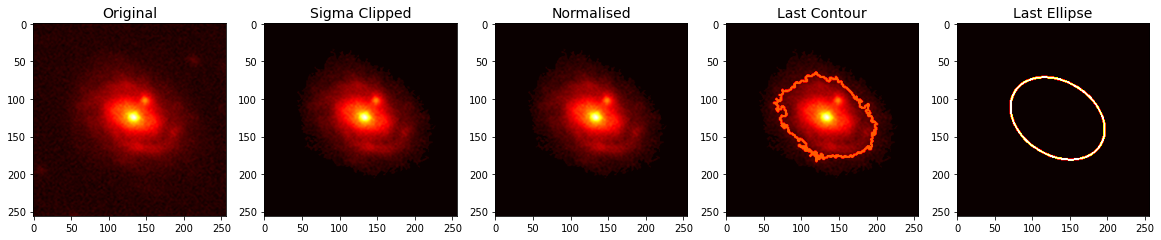

[3.21960449e-02 6.32324219e-02 9.03472900e-02 1.24114990e-01
 1.57165527e-01 3.15048218e-01 0.00000000e+00 3.07240816e+00
 3.92726039e+00 4.76073912e+00 5.25005184e+00 4.07045224e+00
 1.00000000e+00 9.03330214e-01 1.03165149e+00 1.12623744e+00
 1.06383999e+00 1.03035809e+00 0.00000000e+00 2.30635300e+01
 4.31844177e+01 2.98370514e+01 2.19152451e+01 2.28959351e+01]


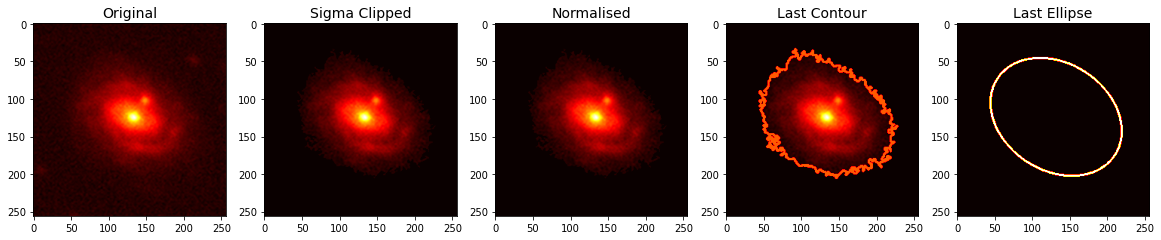

In [18]:
contours_and_ellipses(good_image_data[0], percentiles)

NameError: name 'g1' is not defined

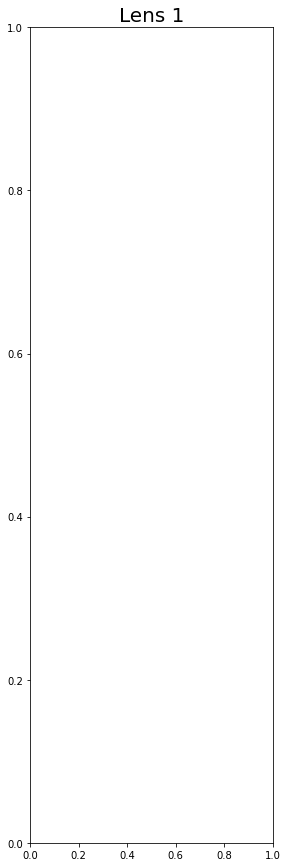

In [20]:
f = plt.figure(figsize = (20,15))

f.add_subplot(1,4, 1)
plt.title('Lens 1', fontsize = 20)
plt.imshow(mpimg.imread(g1))
        
f.add_subplot(1,4, 2)
plt.title('Lens 2', fontsize = 20)
plt.imshow(mpimg.imread(g2))
        
f.add_subplot(1,4, 3)
plt.title('Lens 3', fontsize = 20)
plt.imshow(mpimg.imread(g3))      
        
f.add_subplot(1,4, 4)
plt.title('Lens 4', fontsize = 20)
plt.imshow(mpimg.imread(g4))
            
plt.show(block=True)

# Funtion to use

In [43]:
def contours_and_ellipses(image, percentiles):
    
    #this_image = image_transform_scale(image)
    #image = image_transform_sigma_clipping(this_image, sigma=3, central=True)
    
    
    this_image = image_transform_sigma_clipping(image, sigma=3, central=True)
    #image = this_image
    image = image_transform_scale(this_image)
    
    x0 = y0 = -1
    x_cent = image.shape[0] // 2
    y_cent = image.shape[1] // 2
    
    feats = []
    # Start with the closest in contour (highest percentile)
    percentiles = np.sort(percentiles)[::-1] 

    if np.all(image == 0):
        failed = True
        failure_message = "Invalid cutout for feature extraction"
    else:
        failed = False
        failure_message = ""

    for p in percentiles:
        if failed:
            contours = []
        else:
            thresh = np.percentile(image[image > 0], p)
            contours, hierarchy = find_contours(image, thresh)

            x_contours = np.zeros(len(contours))
            y_contours = np.zeros(len(contours))
        
            if len(contours[0]) != 0:
                for k in range(len(contours)):
                    M = cv2.moments(contours[k])
                    try:
                        x_contours[k] = int(M["m10"] / M["m00"])
                        y_contours[k] = int(M["m01"] / M["m00"])
                    except ZeroDivisionError:
                        pass
                if x0 == -1:
                    x_diff = x_contours - x_cent
                    y_diff = y_contours - y_cent
                else:
                    x_diff = x_contours - x0
                    y_diff = y_contours - y0
                
                # Will try to find the CLOSEST contour to the central one
                r_diff = np.sqrt(x_diff**2 + y_diff**2)

                ind = np.argmin(r_diff)

                if x0 == -1:
                    x0 = x_contours[ind]
                    y0 = y_contours[ind]

                c = contours[ind]
                
           ######### Added ALL of this to test for differences
        
                params = get_ellipse_leastsq(c, image)
                # Params return in this order:
                # residual, x0, y0, maj_axis, min_axis, theta
                if np.any(np.isnan(params)):
                    failed = True
                else:
                    if params[3] == 0 or params[4] == 0:
                        aspect = 1
                    else:
                        aspect = params[4] / params[3]

                    if aspect < 1:
                        aspect = 1 / aspect
                    if aspect > 100:
                        aspect = 1                
                
                    new_params = params[:3] + [aspect] + [params[-1]]
                    feats.append(new_params)
            else:
                failed = True
                failure_message = "No contour found"

            if failed:
                feats.append([np.nan] * 5)
                logging_tools.log(failure_message)
            
        # Now we have the leastsq value, x0, y0, aspect_ratio, theta for each 
        # sigma
        # Normalise things relative to the highest threshold value
        # If there were problems with any sigma levels, set all values to NaNs
        if np.any(np.isnan(feats)):
            return [np.nan] * 4 * len(percentiles)
        else:
            max_ind = np.argmax(percentiles)

            residuals = []
            dist_to_centre = []
            aspect = []
            theta = []

            x0_max_sigma = feats[max_ind][1]
            y0_max_sigma = feats[max_ind][2]
            aspect_max_sigma = feats[max_ind][3]
            theta_max_sigma = feats[max_ind][4]

            for n in range(len(feats)):
                prms = feats[n]
                residuals.append(prms[0])
                if prms[1] == 0 or prms[2] == 0:
                    r = 0
                else:
                    x_diff = prms[1] - x0_max_sigma
                    y_diff = prms[2] - y0_max_sigma
                    r = np.sqrt((x_diff)**2 + (y_diff)**2)
                dist_to_centre.append(r)
                aspect.append(prms[3] / aspect_max_sigma)
                theta_diff = np.abs(prms[4] - theta_max_sigma) % 360
                # Because there's redundancy about which way an ellipse 
                # is aligned, we always take the acute angle
                if theta_diff > 90:
                    theta_diff -= 90
                theta.append(theta_diff)

            normalized_parameters = np.hstack((residuals, dist_to_centre, aspect, theta))
            
            #########
            
        thickness = 2
            
        y_npix = image.shape[0]
        x_npix = image.shape[1]
            
        contour_arr = np.zeros([y_npix, x_npix], dtype=np.float)
            
        arr = image.copy()
            
        cnt = cv2.drawContours(arr, [c], 0, (0.9, 0, 0), thickness)
            
        ellipse_arr, params = fit_ellipse(c, image, return_params=True)

        print('Percentile is :' ,p)
        print( 'Parameters are :' ,params)
        #print(normalized_parameters)
            
            # Display the contours and ellipses
        f = plt.figure(figsize = (15,15))
            
        f.add_subplot(1,2, 1)
        #plt.imshow(image, cmap='gray')
        plt.imshow(cnt, cmap='hot')

        f.add_subplot(1,2, 2)
        plt.imshow(ellipse_arr, cmap='hot')
            
        plt.show(block=True)

Percentile is : 90
Parameters are : (139.50616455078125, 117.47342681884766, 32.71144485473633, 42.21086883544922, 123.34685516357422)


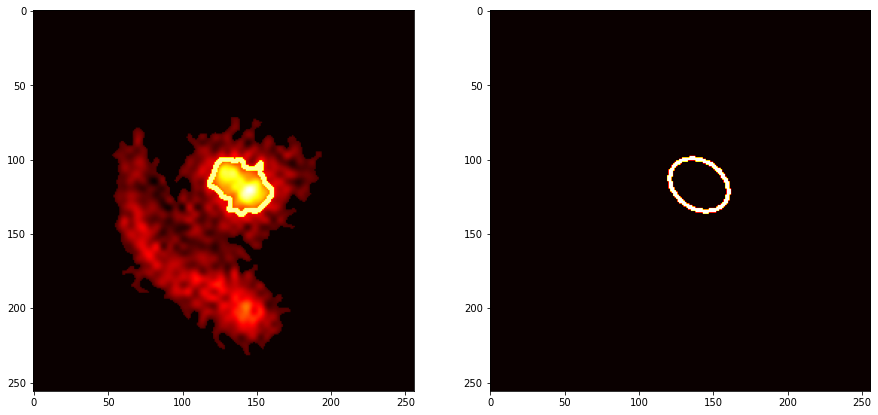

Percentile is : 80
Parameters are : (139.01759338378906, 117.27245330810547, 39.83294677734375, 50.21549606323242, 121.26353454589844)


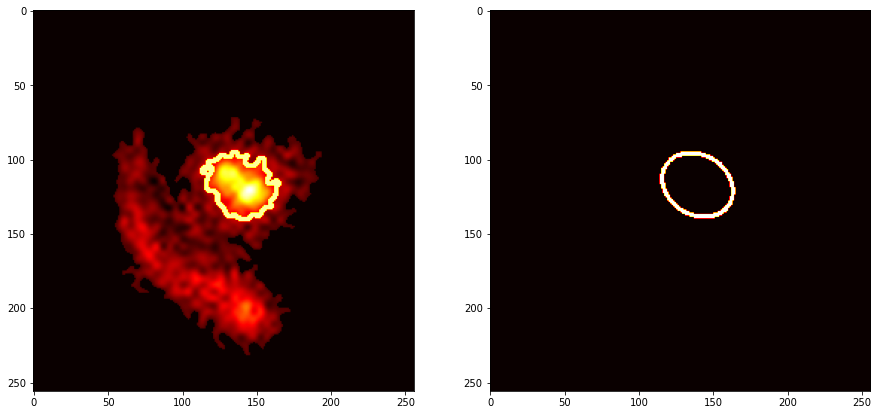

Percentile is : 70
Parameters are : (140.51437377929688, 117.62619018554688, 43.58439254760742, 56.81218719482422, 112.51181030273438)


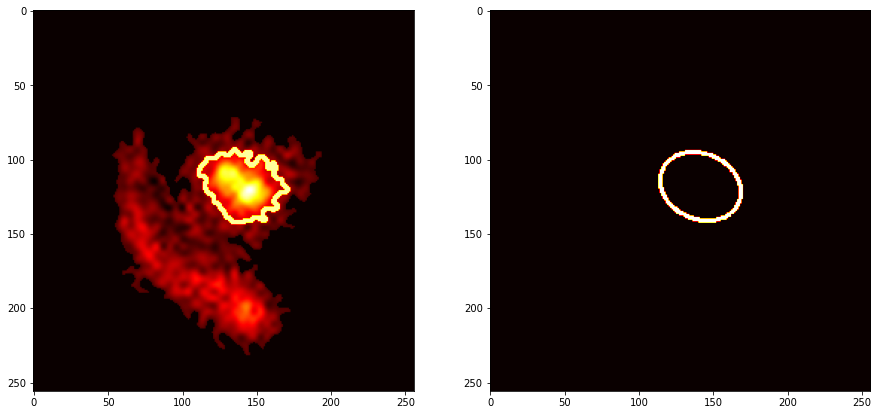

Percentile is : 60
Parameters are : (138.99806213378906, 118.22026824951172, 49.02771759033203, 61.8064079284668, 114.77278137207031)


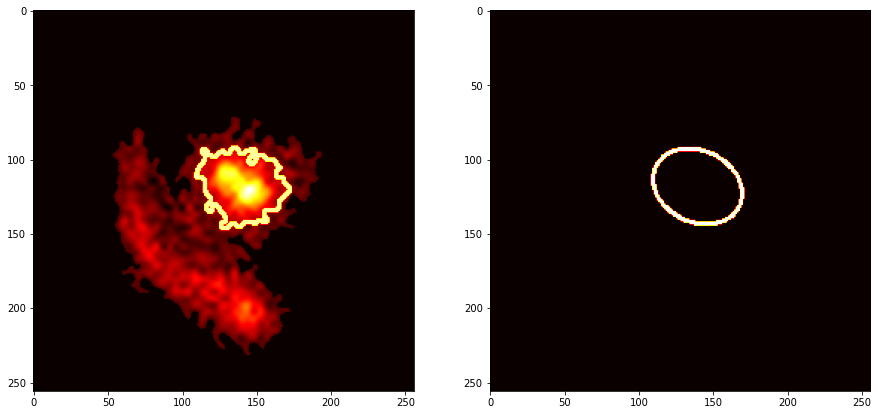

Percentile is : 50
Parameters are : (140.79049682617188, 117.94380950927734, 56.37101364135742, 64.93280029296875, 113.4285659790039)


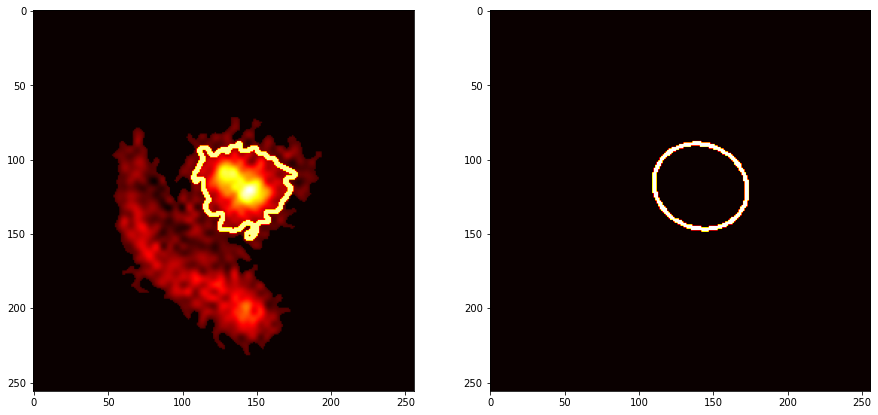

Percentile is : 0
Parameters are : (122.41252136230469, 144.93714904785156, 129.64210510253906, 145.37596130371094, 179.4942626953125)


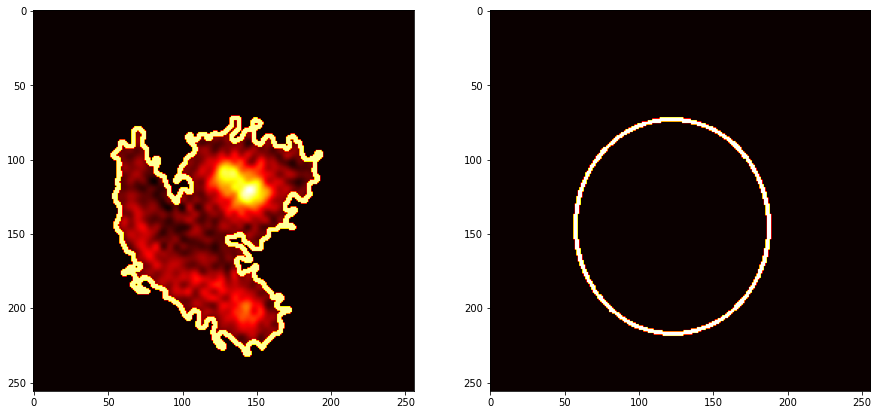

In [44]:
contours_and_ellipses(image_g4_data_z, percentiles)

## Failed Images

#### Image 1 - id 66

Percentile is : 90
Parameters are : (132.89987182617188, 121.1827163696289, 28.409435272216797, 65.16228485107422, 71.17584228515625)


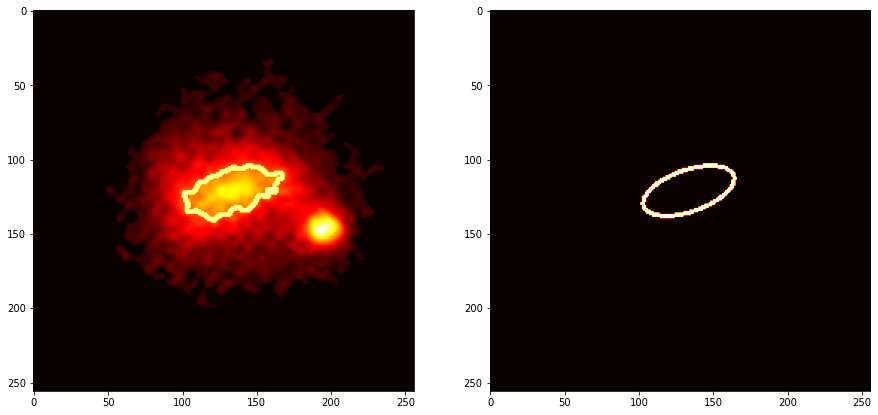

Percentile is : 80
Parameters are : (143.65310668945312, 127.58811950683594, 54.77203369140625, 109.69129943847656, 104.58352661132812)


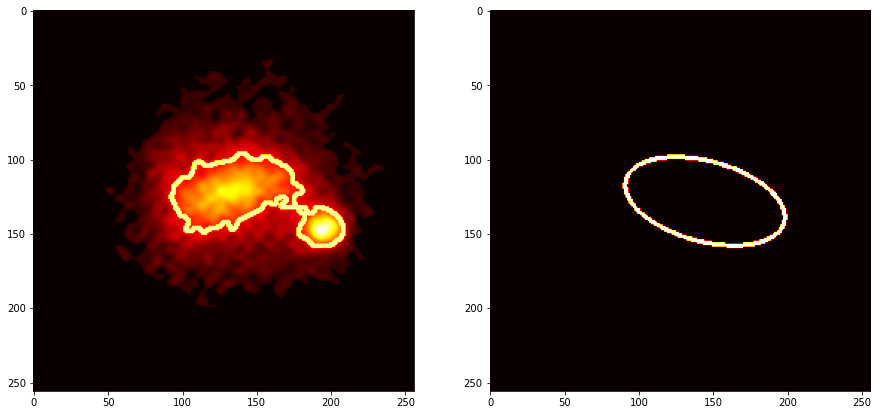

Percentile is : 70
Parameters are : (141.76968383789062, 126.94242095947266, 66.60992431640625, 123.26805877685547, 97.46232604980469)


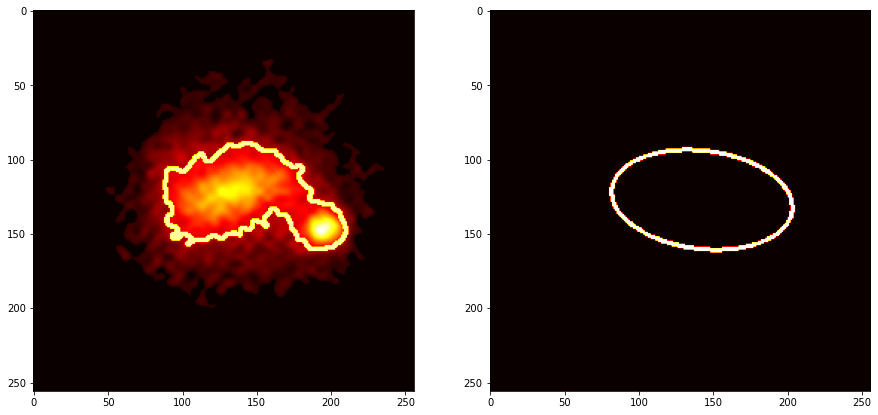

Percentile is : 60
Parameters are : (142.2775115966797, 125.21504974365234, 75.50382232666016, 134.269287109375, 98.4675064086914)


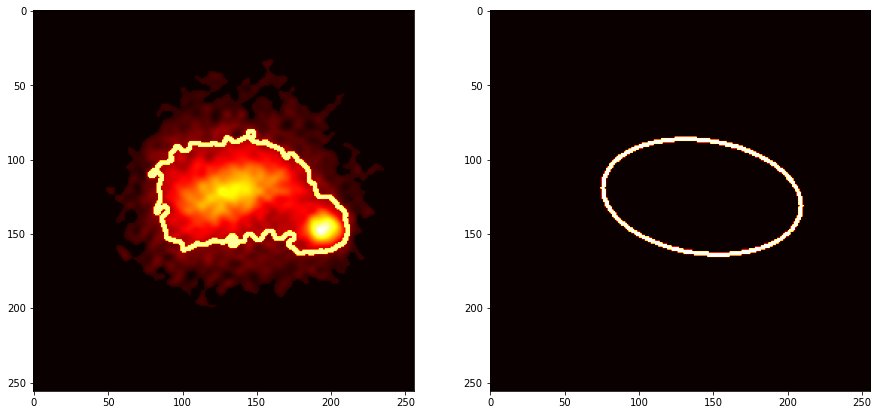

Percentile is : 50
Parameters are : (139.16285705566406, 125.12935638427734, 86.76856994628906, 141.84385681152344, 98.05183410644531)


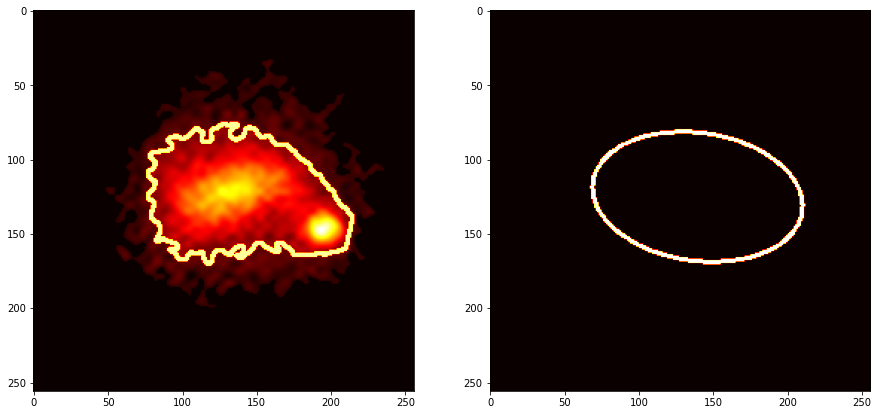

Percentile is : 0
Parameters are : (140.46800231933594, 122.10108947753906, 146.7713623046875, 166.46469116210938, 87.72015380859375)


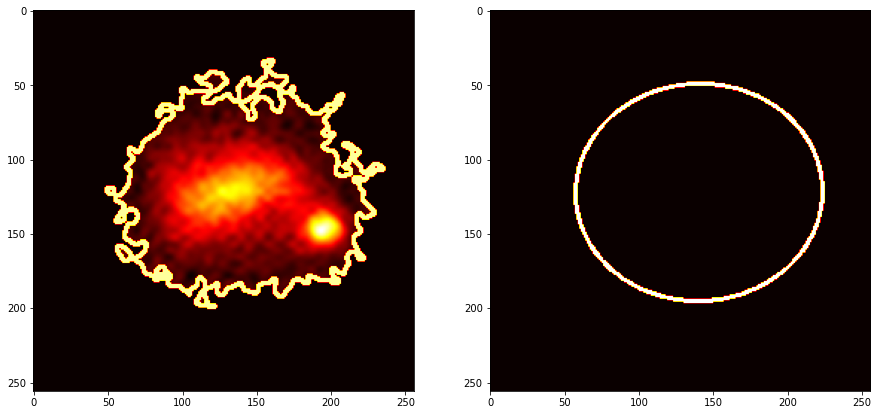

In [45]:
image_1 = '/home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/Failed Images/cutout_26.0835_-6.3682.fits'

image_1_data = fits.getdata(image_1)

image_1_data_g = image_1_data[0]
image_1_data_r = image_1_data[1]
image_1_data_z = image_1_data[2]

contours_and_ellipses(image_1_data_g, percentiles)

#### Image 2 - id 6579

In [46]:
image_2 = '/home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/Failed Images/cutout_25.9945_-6.1846.fits'

image_2_data = fits.getdata(image_2)

image_2_data_g = image_2_data[0]
image_2_data_r = image_2_data[1]
image_2_data_z = image_2_data[2]

contours_and_ellipses(image_2_data_z, percentiles)

FileNotFoundError: [Errno 2] No such file or directory: ''

#### Image 3 - id 565

Percentile is : 90
Parameters are : (149.3580780029297, 29.641925811767578, 3.0614020824432373, 3.7628066539764404, 45.0)


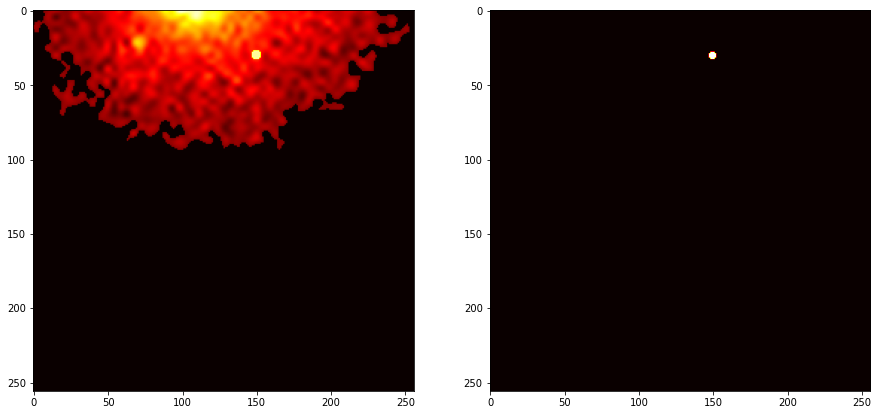

Percentile is : 80
Parameters are : (141.0, 38.0, 4.4303765296936035, 6.284537315368652, 163.0968017578125)


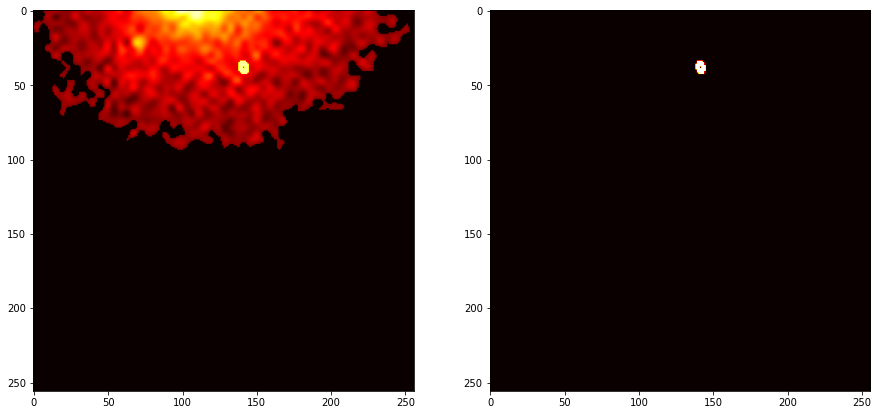

FileNotFoundError: [Errno 2] No such file or directory: ''

In [47]:
image_3 = '/home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/Failed Images/cutout_26.1271_-6.3500.fits'

image_3_data = fits.getdata(image_3)

image_3_data_g = image_3_data[0]
image_3_data_r = image_3_data[1]
image_3_data_z = image_3_data[2]

contours_and_ellipses(image_3_data_z, percentiles)

#### Image 4 - id 1361

Percentile is : 90
Parameters are : (135.03416442871094, 134.55934143066406, 90.72763061523438, 108.97052764892578, 37.083126068115234)


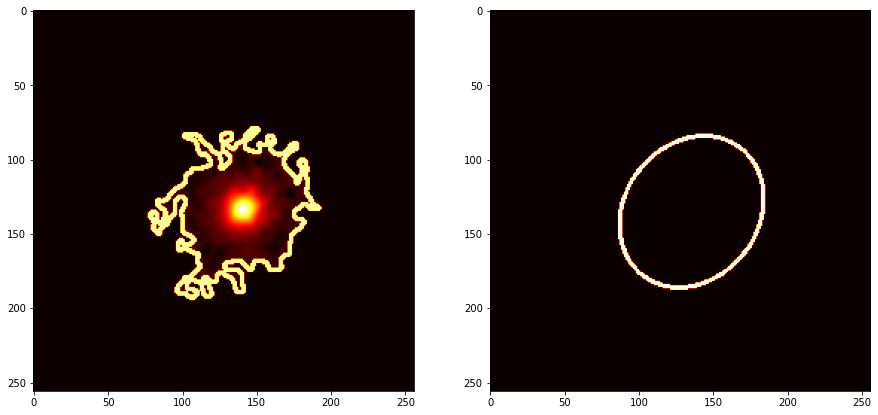

Percentile is : 80
Parameters are : (135.03416442871094, 134.55934143066406, 90.72763061523438, 108.97052764892578, 37.083126068115234)


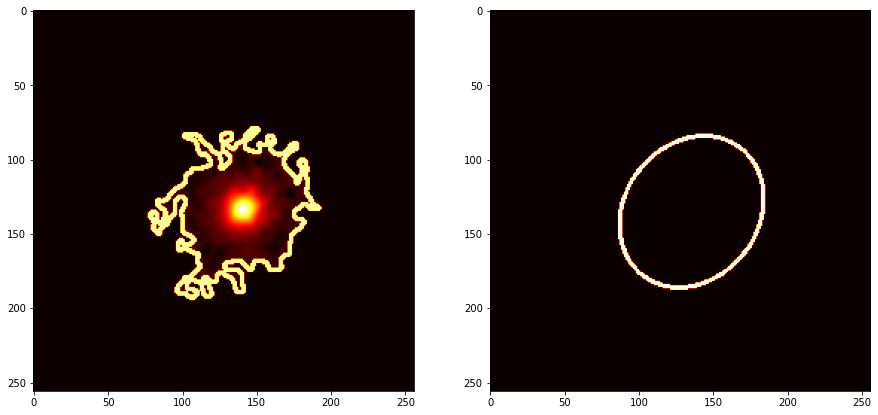

Percentile is : 70
Parameters are : (135.03416442871094, 134.55934143066406, 90.72763061523438, 108.97052764892578, 37.083126068115234)


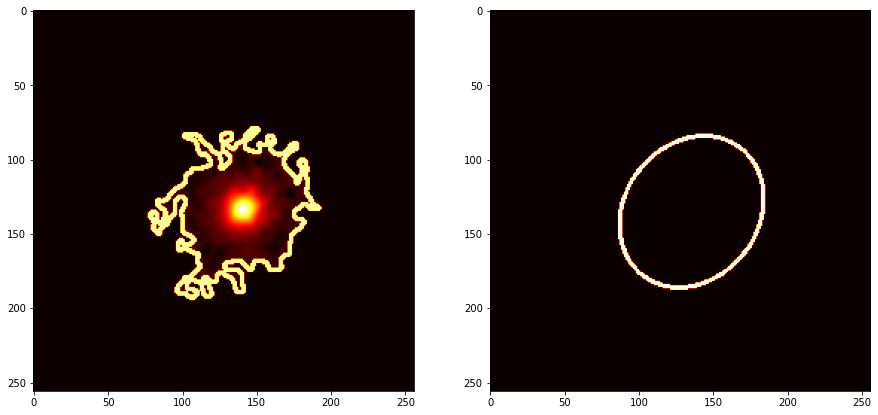

Percentile is : 60
Parameters are : (135.03416442871094, 134.55934143066406, 90.72763061523438, 108.97052764892578, 37.083126068115234)


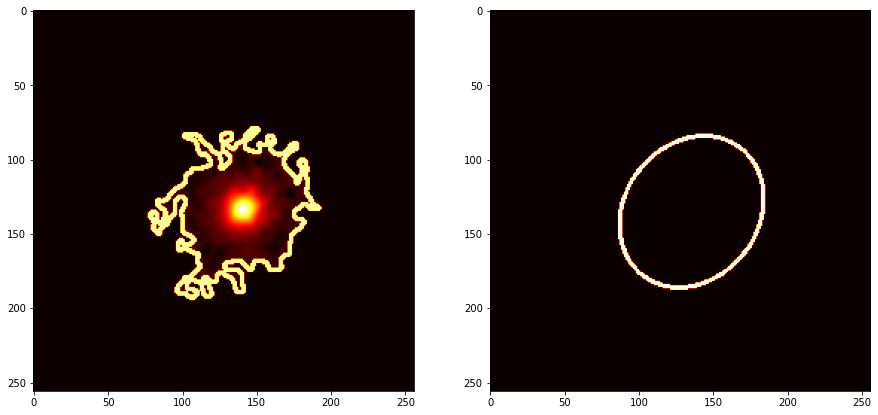

Percentile is : 50
Parameters are : (135.03416442871094, 134.55934143066406, 90.72763061523438, 108.97052764892578, 37.083126068115234)


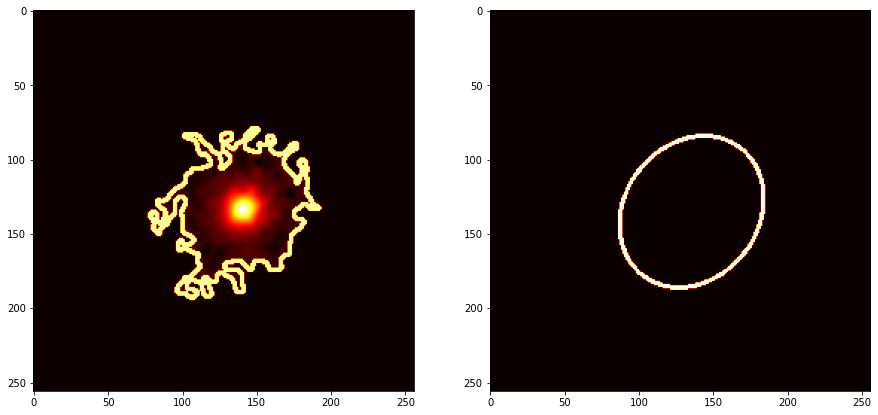

FileNotFoundError: [Errno 2] No such file or directory: ''

In [48]:
image_4 = '/home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/Failed Images/cutout_26.1192_-6.3357.fits'

image_4_data = fits.getdata(image_4)

image_4_data_g = image_4_data[0]
image_4_data_r = image_4_data[1]
image_4_data_z = image_4_data[2]

contours_and_ellipses(image_4_data_z, percentiles)

#### Image 5 - id 6553

Percentile is : 90
Parameters are : (128.7174835205078, 124.8215103149414, 21.131336212158203, 24.93303871154785, 46.2387580871582)


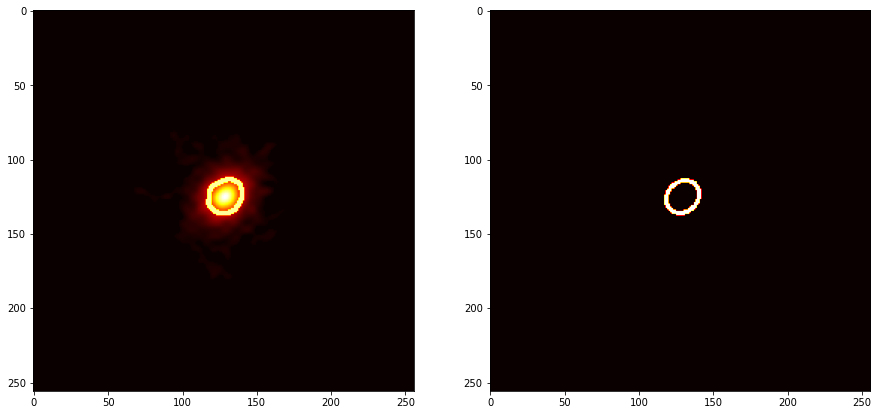

Percentile is : 80
Parameters are : (128.41079711914062, 124.48785400390625, 29.046815872192383, 36.619384765625, 42.51923370361328)


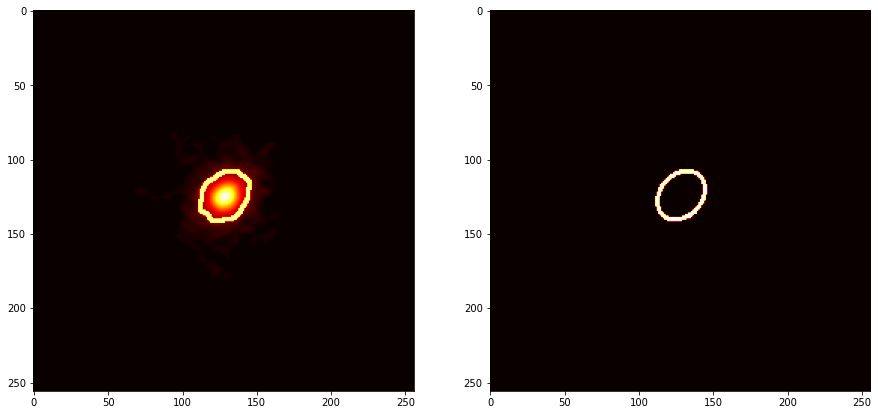

Percentile is : 70
Parameters are : (128.8377227783203, 124.64262390136719, 36.5748176574707, 45.166168212890625, 41.689300537109375)


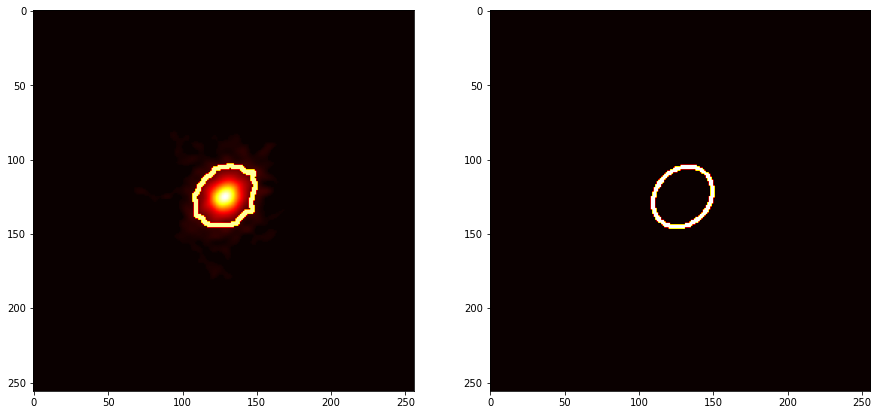

Percentile is : 60
Parameters are : (129.5546112060547, 124.42411041259766, 41.466854095458984, 53.79201889038086, 47.51019287109375)


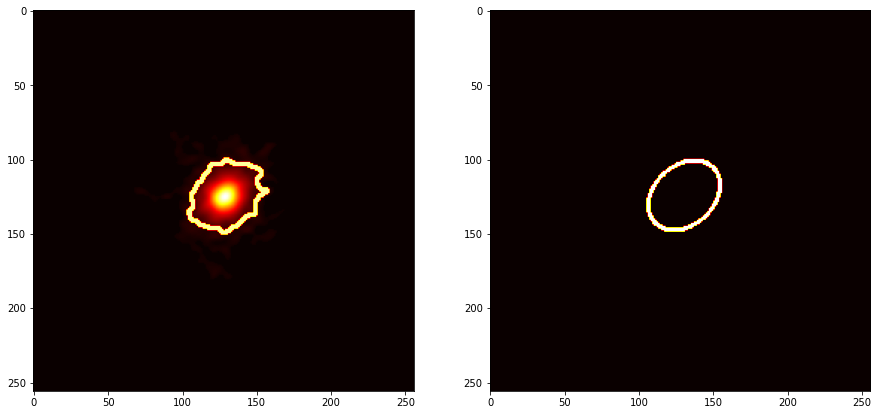

Percentile is : 50
Parameters are : (129.04493713378906, 124.28520202636719, 47.3250846862793, 60.526546478271484, 42.44386672973633)


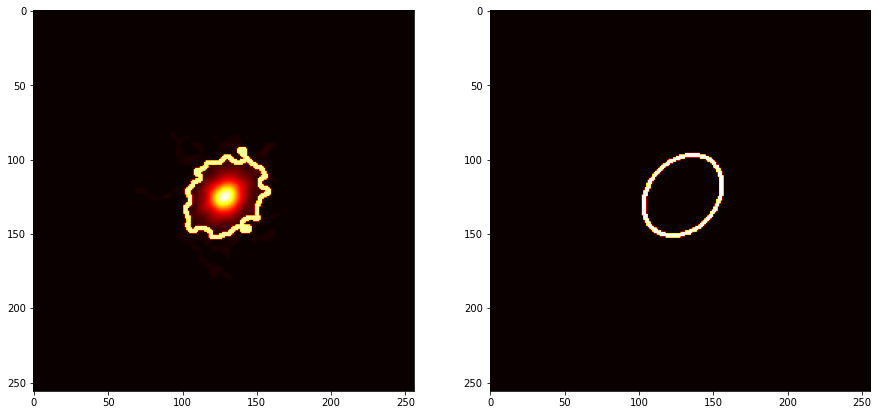

Percentile is : 0
Parameters are : (123.90152740478516, 125.87303924560547, 80.23660278320312, 87.8069076538086, 173.9499053955078)


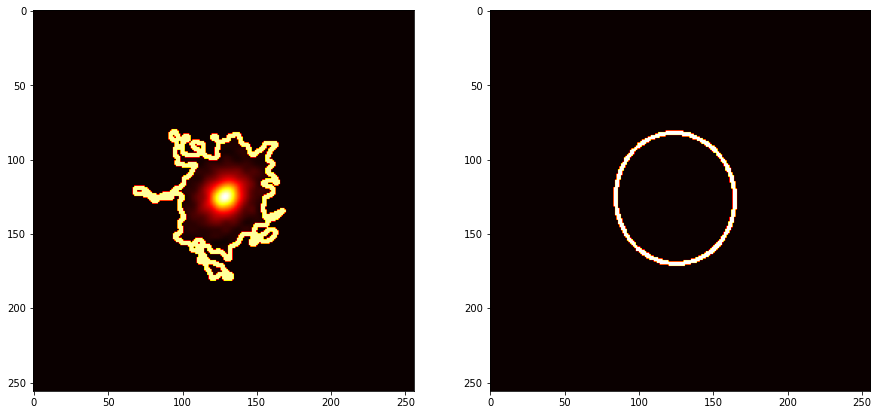

In [27]:
image_5 = '/home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/Failed Images/cutout_25.9787_-6.1877.fits'

image_5_data = fits.getdata(image_5)

image_5_data_g = image_5_data[0]
image_5_data_r = image_5_data[1]
image_5_data_z = image_5_data[2]

contours_and_ellipses(image_5_data_z, percentiles)

#### Image 6 - id 1337

Percentile is : 90
Parameters are : (128.9002685546875, 129.66380310058594, 76.07044982910156, 85.76231384277344, 35.91671371459961)


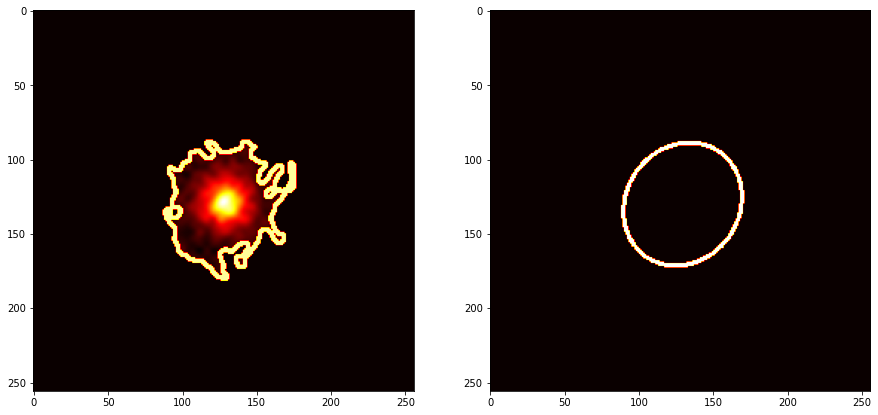

Percentile is : 80
Parameters are : (128.9002685546875, 129.66380310058594, 76.07044982910156, 85.76231384277344, 35.91671371459961)


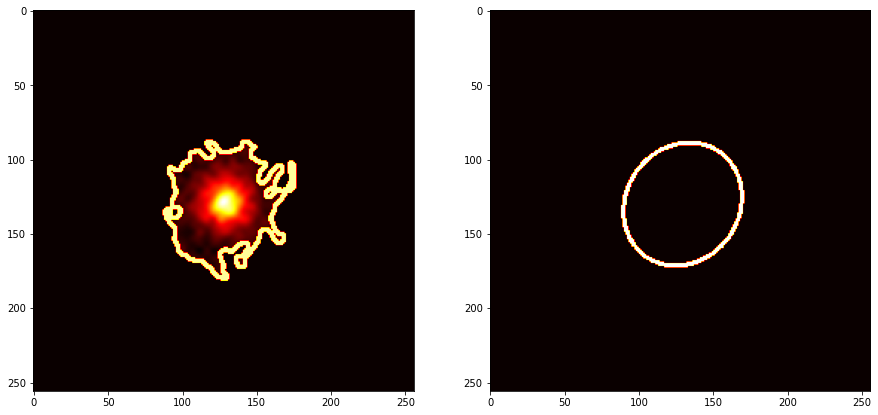

Percentile is : 70
Parameters are : (128.9002685546875, 129.66380310058594, 76.07044982910156, 85.76231384277344, 35.91671371459961)


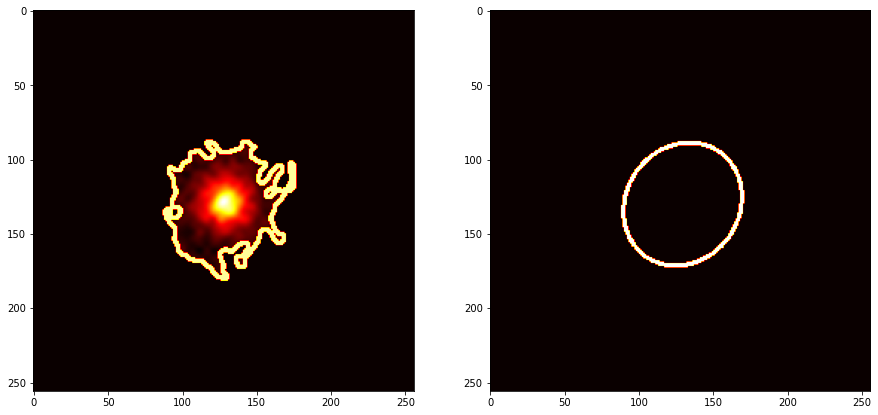

Percentile is : 60
Parameters are : (128.9002685546875, 129.66380310058594, 76.07044982910156, 85.76231384277344, 35.91671371459961)


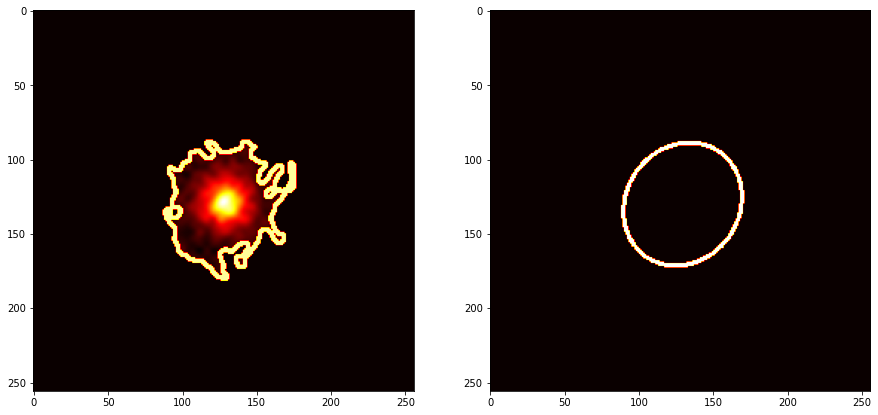

Percentile is : 50
Parameters are : (128.9002685546875, 129.66380310058594, 76.07044982910156, 85.76231384277344, 35.91671371459961)


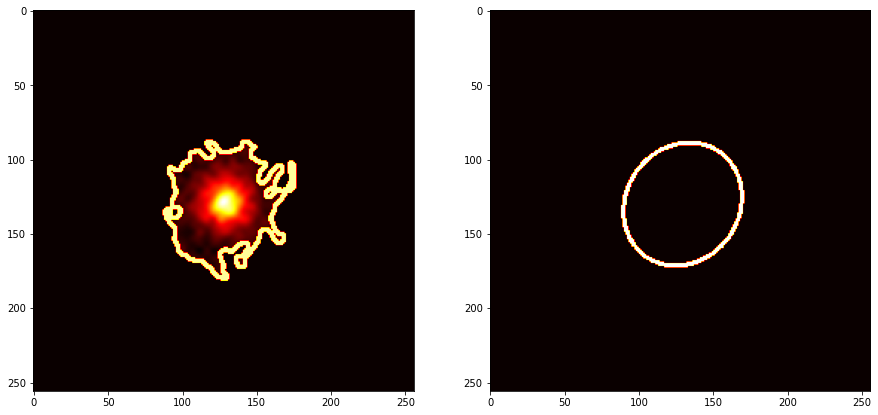

Percentile is : 0
Parameters are : (128.9002685546875, 129.66380310058594, 76.07044982910156, 85.76231384277344, 35.91671371459961)


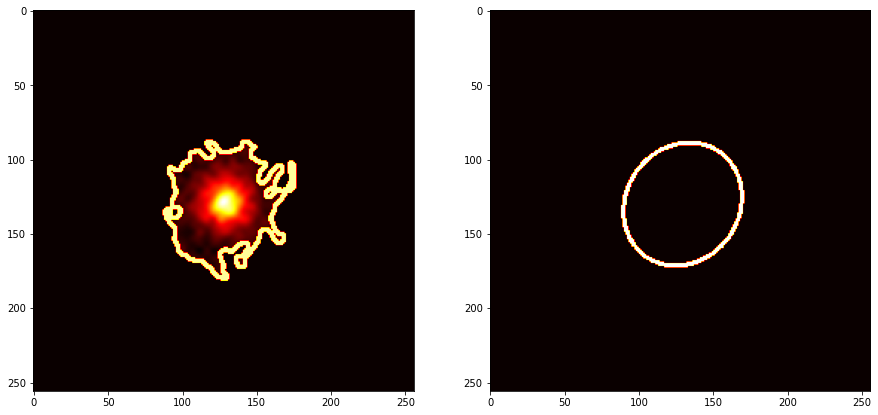

In [28]:
image_6 = '/home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/Failed Images/cutout_25.9174_-6.3364.fits'

image_6_data = fits.getdata(image_6)

image_6_data_g = image_6_data[0]
image_6_data_r = image_6_data[1]
image_6_data_z = image_6_data[2]

contours_and_ellipses(image_6_data_z, percentiles)

#### Image 7 - id 575

Percentile is : 90
Parameters are : (186.8000030517578, 4.0, 1.3935457468032837, 4.694278240203857, 150.59115600585938)


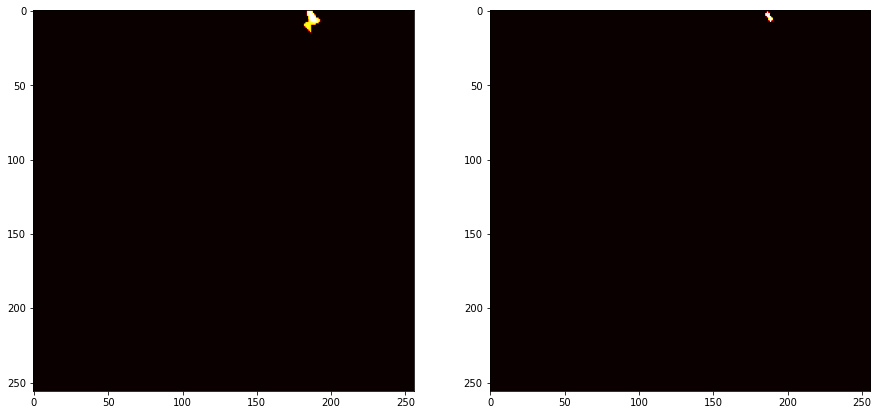

Percentile is : 80
Parameters are : (186.86126708984375, 4.002139091491699, 2.2426156997680664, 7.0808186531066895, 151.8963623046875)


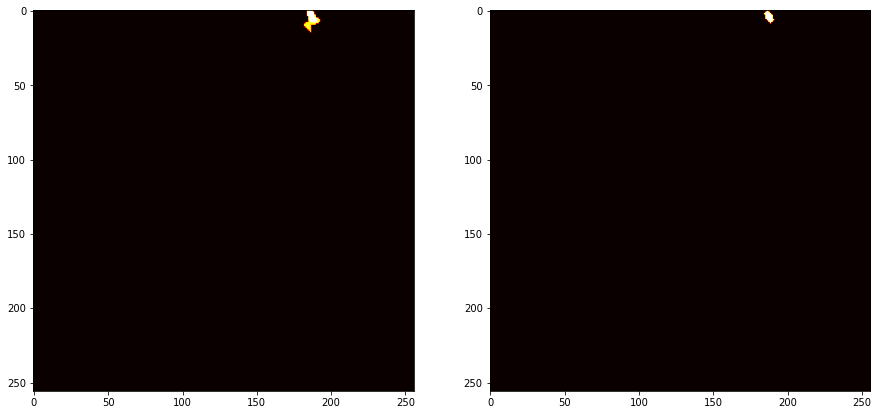

Percentile is : 70
Parameters are : (187.2918243408203, 4.457370758056641, 3.2021188735961914, 8.061751365661621, 144.66761779785156)


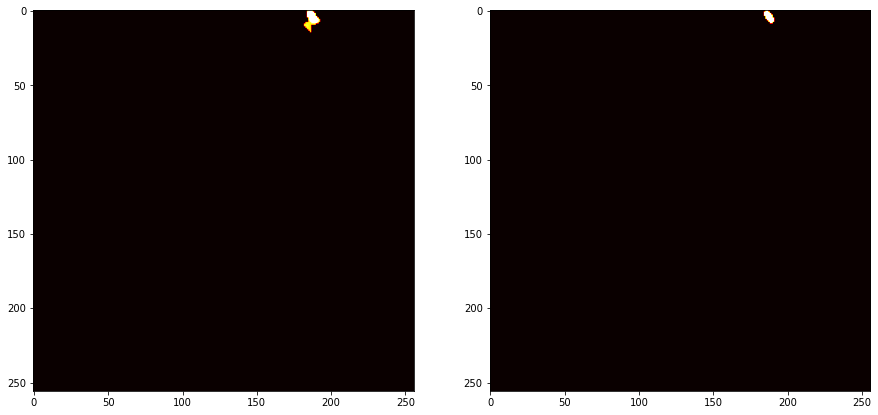

Percentile is : 60
Parameters are : (187.1722869873047, 4.01876163482666, 3.8734235763549805, 9.143813133239746, 145.76747131347656)


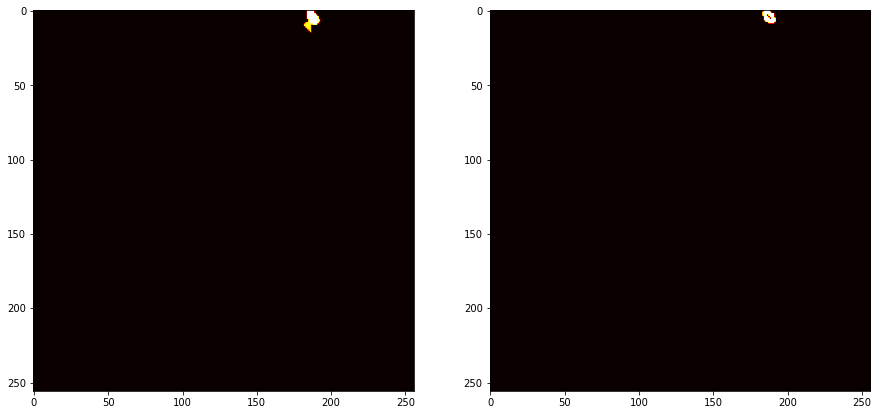

Percentile is : 50
Parameters are : (187.5427703857422, 4.430906772613525, 4.649013042449951, 9.786264419555664, 144.84242248535156)


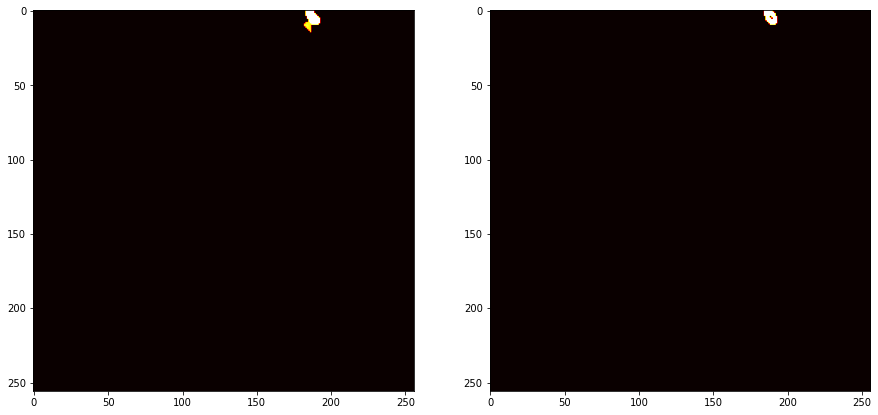

Percentile is : 0
Parameters are : (186.7731475830078, 6.546013355255127, 9.1732816696167, 12.608593940734863, 2.3633246421813965)


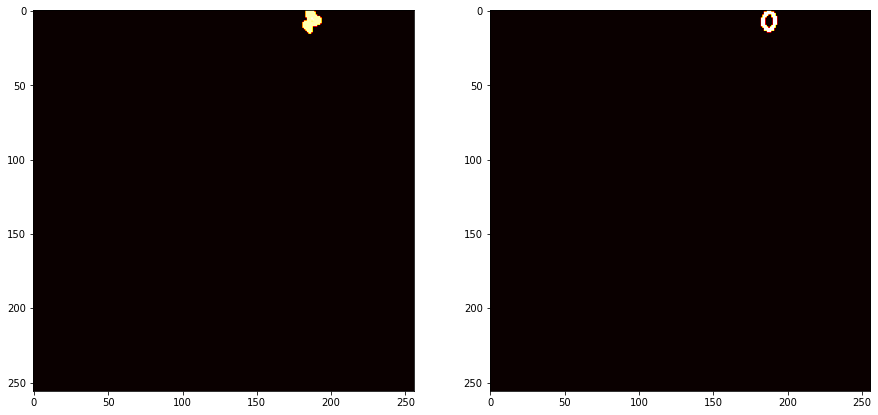

In [29]:
image_7 = '/home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/Failed Images/cutout_26.1283_-6.3589.fits'

image_7_data = fits.getdata(image_7)

image_7_data_g = image_7_data[0]
image_7_data_r = image_7_data[1]
image_7_data_z = image_7_data[2]

contours_and_ellipses(image_7_data_z, percentiles)

#### Image 8 - id 4409

Percentile is : 90
Parameters are : (136.3639678955078, 128.8867645263672, 72.61808013916016, 97.14804077148438, 160.73965454101562)


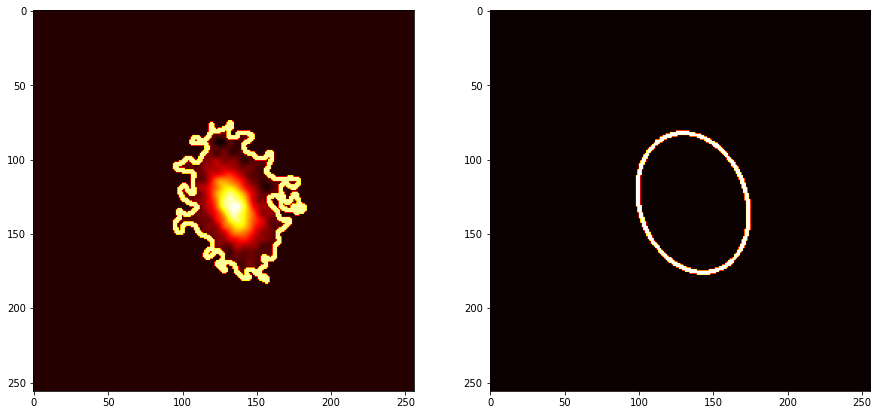

Percentile is : 80
Parameters are : (136.3639678955078, 128.8867645263672, 72.61808013916016, 97.14804077148438, 160.73965454101562)


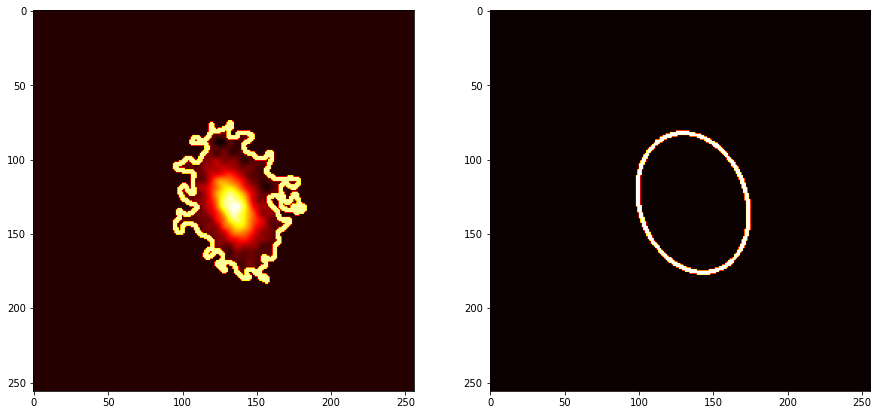

Percentile is : 70
Parameters are : (136.3639678955078, 128.8867645263672, 72.61808013916016, 97.14804077148438, 160.73965454101562)


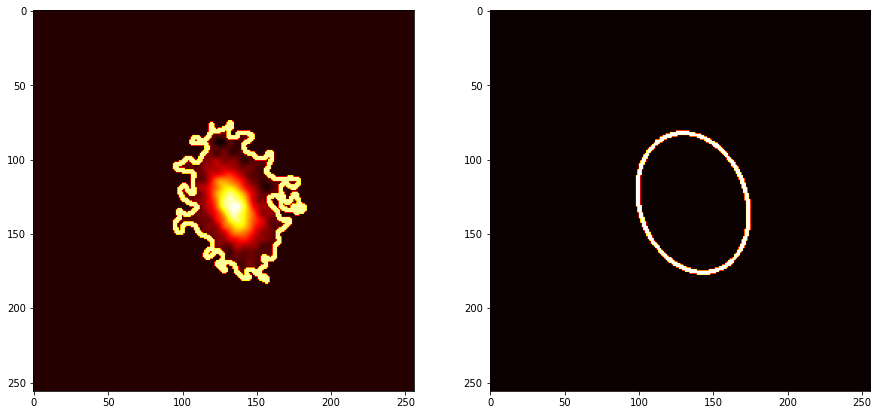

Percentile is : 60
Parameters are : (136.3639678955078, 128.8867645263672, 72.61808013916016, 97.14804077148438, 160.73965454101562)


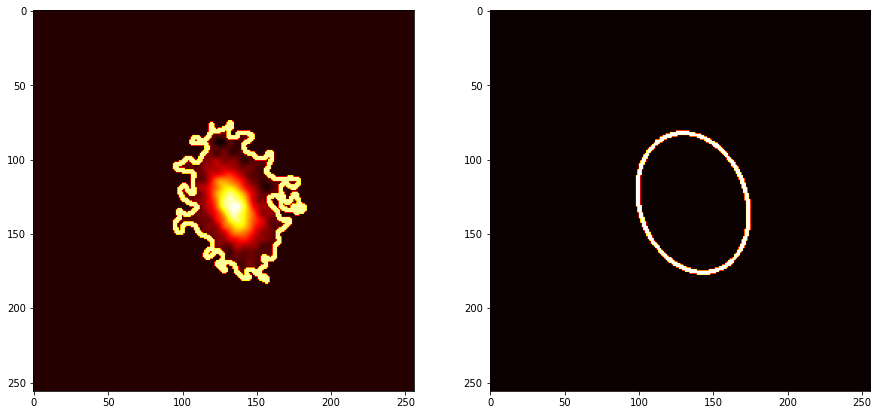

Percentile is : 50
Parameters are : (136.3639678955078, 128.8867645263672, 72.61808013916016, 97.14804077148438, 160.73965454101562)


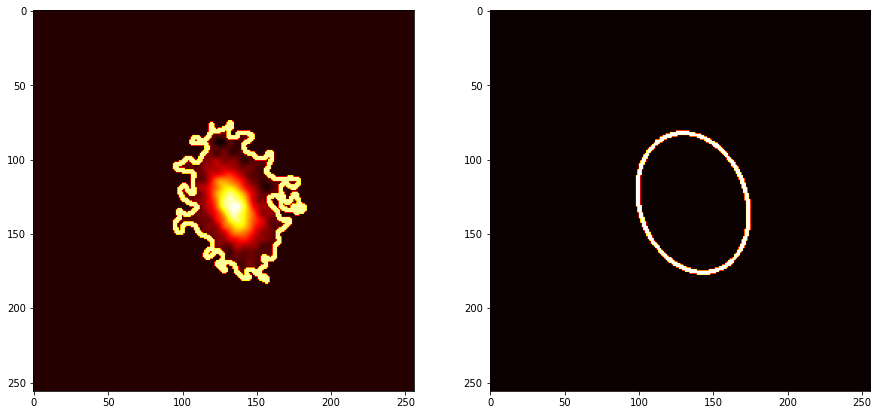

FileNotFoundError: [Errno 2] No such file or directory: ''

In [30]:
image_8 = '/home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/Failed Images/cutout_25.9373_-6.2533.fits'

image_8_data = fits.getdata(image_8)

image_8_data_g = image_8_data[0]
image_8_data_r = image_8_data[1]
image_8_data_z = image_8_data[2]

contours_and_ellipses(image_8_data_z, percentiles)

#### Image 9 - id 6074

Percentile is : 90
Parameters are : (127.91641998291016, 127.24945068359375, 88.65996551513672, 89.90785217285156, 11.168240547180176)


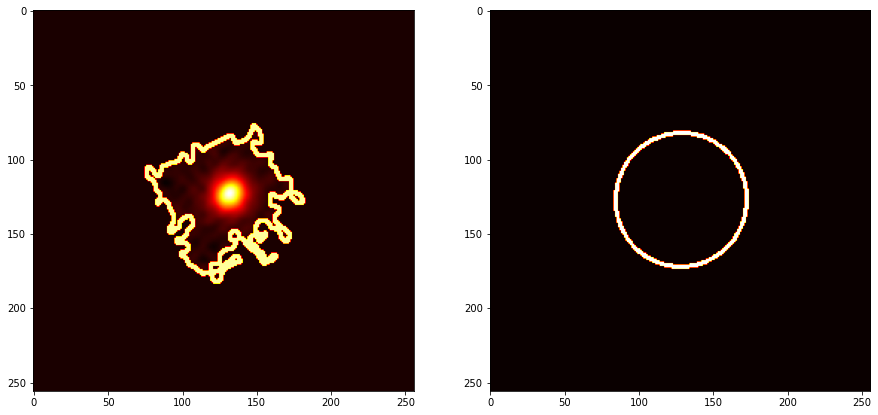

Percentile is : 80
Parameters are : (127.91641998291016, 127.24945068359375, 88.65996551513672, 89.90785217285156, 11.168240547180176)


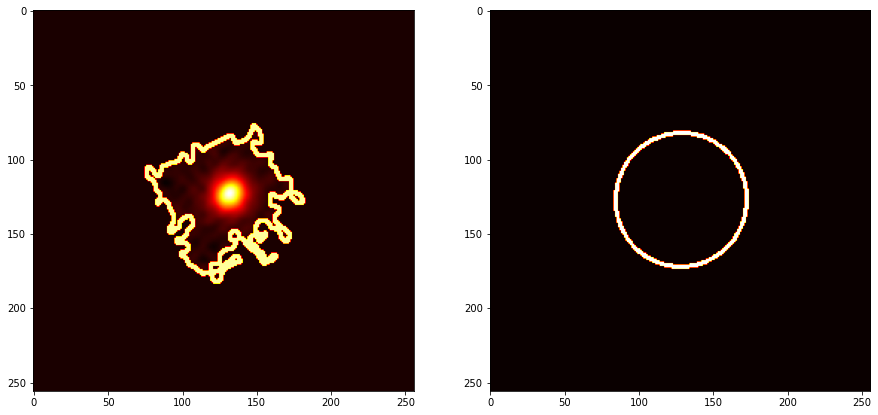

Percentile is : 70
Parameters are : (127.91641998291016, 127.24945068359375, 88.65996551513672, 89.90785217285156, 11.168240547180176)


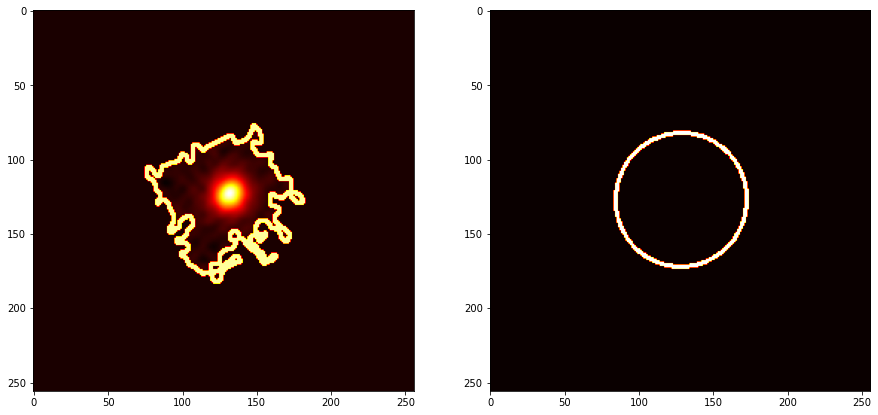

Percentile is : 60
Parameters are : (127.91641998291016, 127.24945068359375, 88.65996551513672, 89.90785217285156, 11.168240547180176)


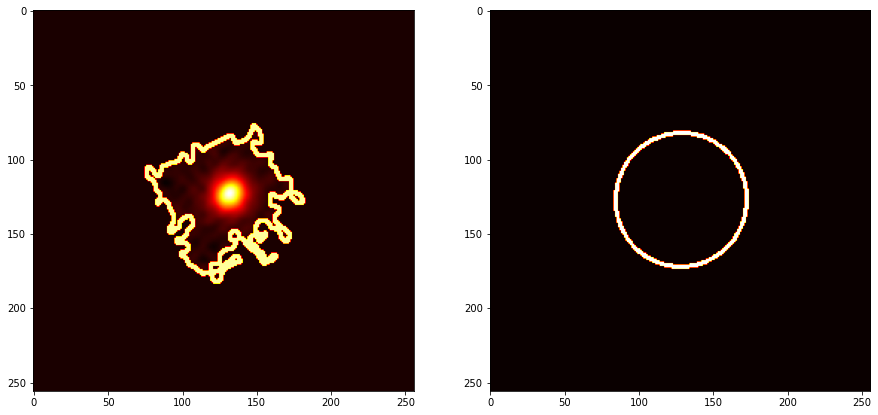

Percentile is : 50
Parameters are : (127.91641998291016, 127.24945068359375, 88.65996551513672, 89.90785217285156, 11.168240547180176)


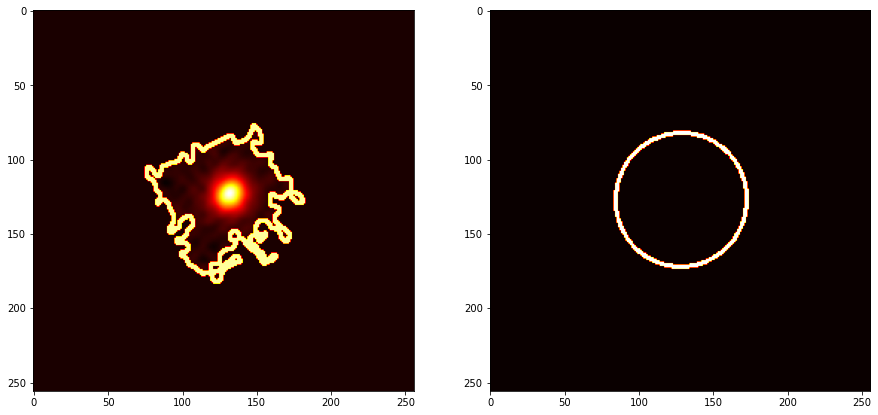

FileNotFoundError: [Errno 2] No such file or directory: ''

In [32]:
image_9 = '/home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/Failed Images/cutout_26.1083_-6.1999.fits'

image_9_data = fits.getdata(image_9)

image_9_data_g = image_9_data[0]
image_9_data_r = image_9_data[1]
image_9_data_z = image_9_data[2]

contours_and_ellipses(image_9_data_z, percentiles)

#### Image 10 - id 8102

Percentile is : 90
Parameters are : (134.89990234375, 119.931884765625, 85.80303955078125, 93.83831787109375, 178.67758178710938)


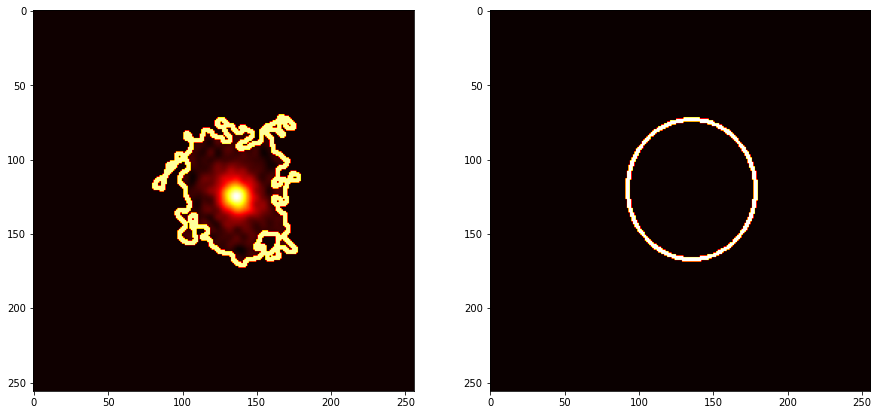

Percentile is : 80
Parameters are : (134.89990234375, 119.931884765625, 85.80303955078125, 93.83831787109375, 178.67758178710938)


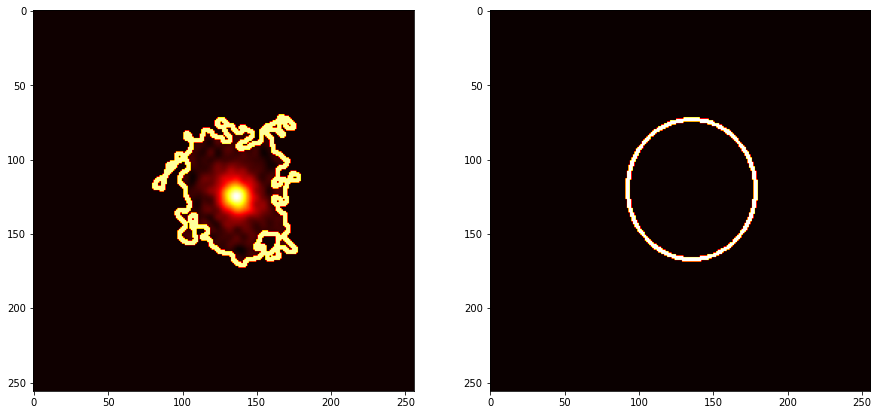

Percentile is : 70
Parameters are : (134.89990234375, 119.931884765625, 85.80303955078125, 93.83831787109375, 178.67758178710938)


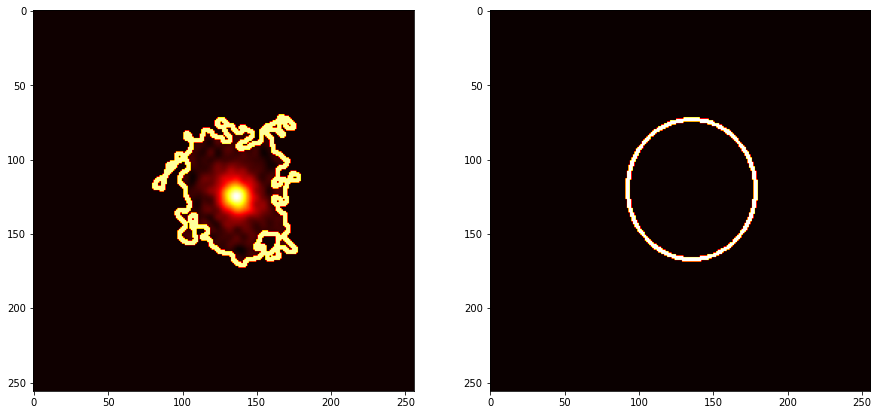

Percentile is : 60
Parameters are : (134.89990234375, 119.931884765625, 85.80303955078125, 93.83831787109375, 178.67758178710938)


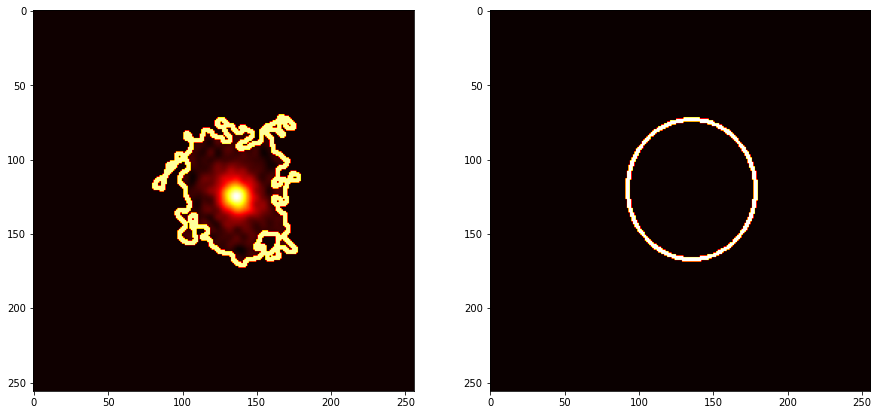

Percentile is : 50
Parameters are : (134.89990234375, 119.931884765625, 85.80303955078125, 93.83831787109375, 178.67758178710938)


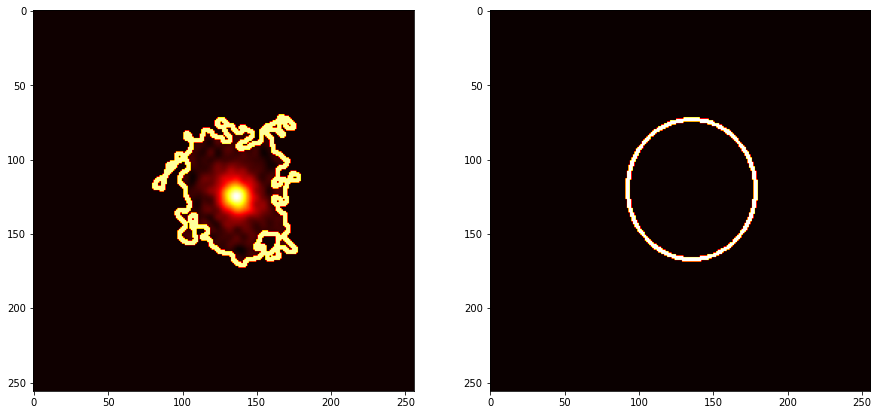

FileNotFoundError: [Errno 2] No such file or directory: ''

In [33]:
image_10 = '/home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/Failed Images/cutout_26.0499_-6.1396.fits'

image_10_data = fits.getdata(image_10)

image_10_data_g = image_10_data[0]
image_10_data_r = image_10_data[1]
image_10_data_z = image_10_data[2]

contours_and_ellipses(image_10_data_z, percentiles)

## Good Samples - Suspected Lenses

#### Image 1

In [ ]:
g1 = '/home/verlon/Desktop/Astronomaly/Data/Input/Known Lenses/cutout g1.jpg'

imgplot = plt.imshow(mpimg.imread(g1))
plt.show()

Percentile is : 90
Parameters are : (134.54498291015625, 123.89167022705078, 34.32270431518555, 37.63577651977539, 164.3814697265625)


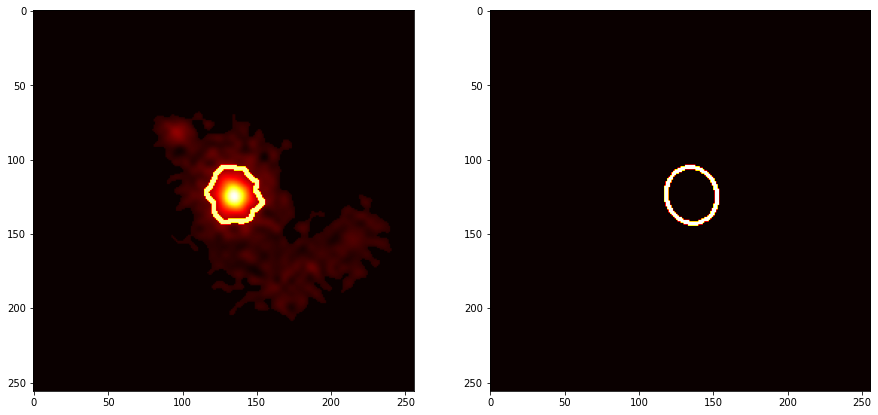

Percentile is : 80
Parameters are : (135.25765991210938, 122.8731460571289, 47.441734313964844, 54.774478912353516, 154.3416748046875)


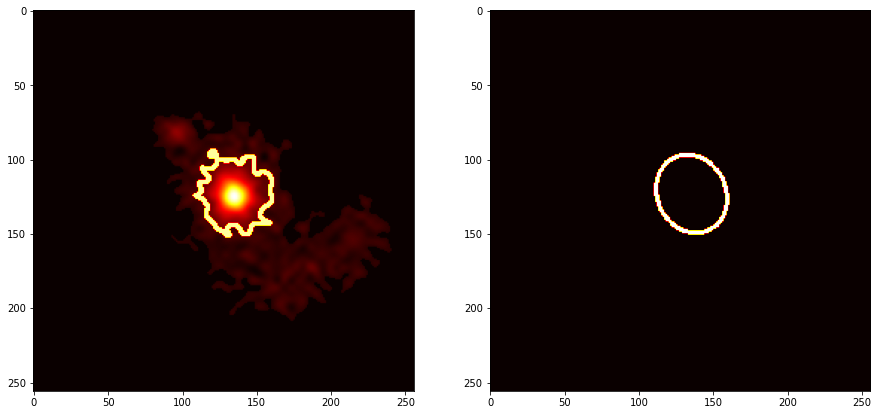

Percentile is : 70
Parameters are : (135.51463317871094, 123.3076171875, 55.280845642089844, 62.39250183105469, 152.7057342529297)


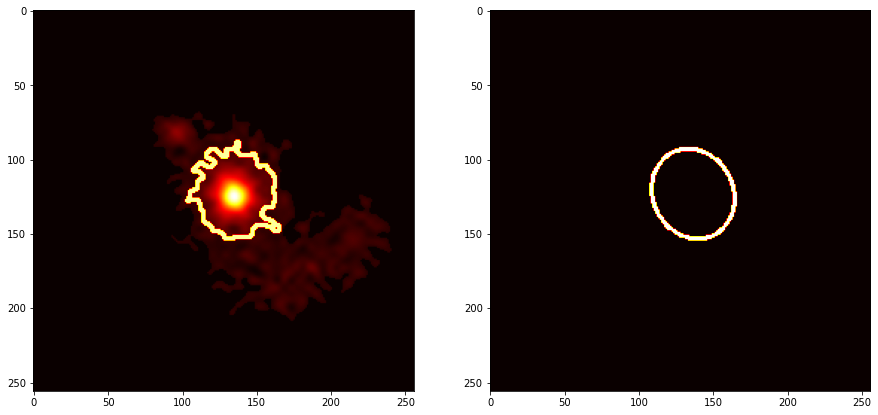

Percentile is : 60
Parameters are : (135.2322540283203, 122.5669937133789, 61.40646743774414, 67.10935974121094, 154.2893829345703)


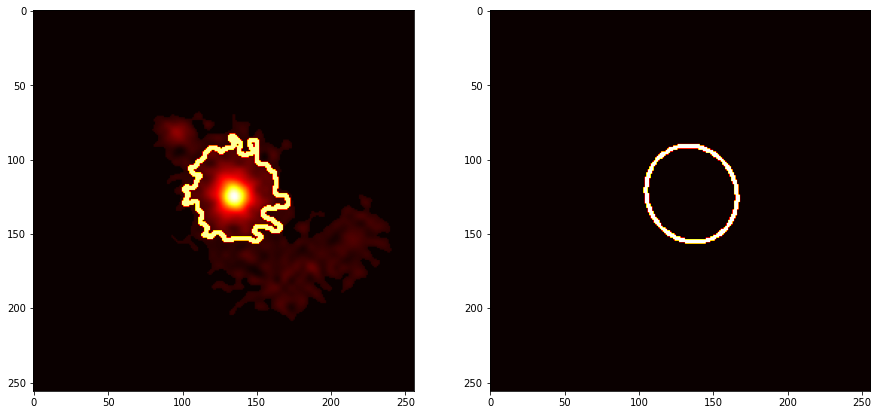

Percentile is : 50
Parameters are : (136.02117919921875, 122.02173614501953, 65.7646484375, 74.77227020263672, 139.82342529296875)


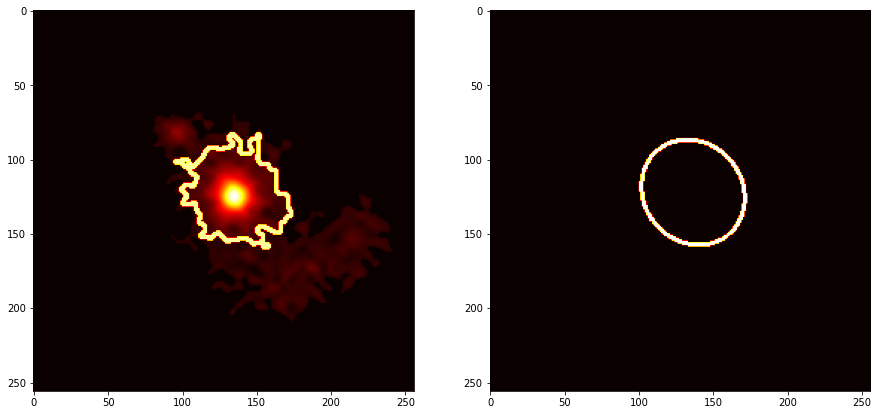

Percentile is : 0
Parameters are : (154.6095428466797, 138.0584259033203, 104.38338470458984, 159.25018310546875, 126.09138488769531)


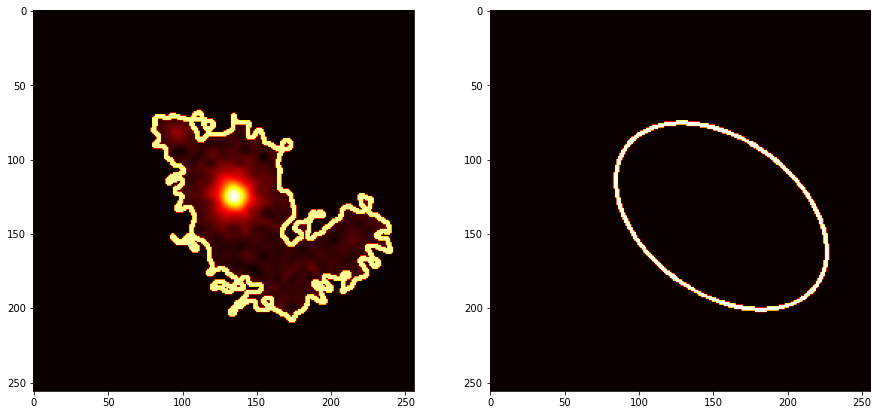

In [34]:
image_g1 = '/home/verlon/Desktop/Astronomaly/Data/Input/Known Lenses/cutout_2.9716_-46.2394.fits'

image_g1_data = fits.getdata(image_g1)

image_g1_data_g = image_g1_data[0]
image_g1_data_r = image_g1_data[1]
image_g1_data_z = image_g1_data[2]

contours_and_ellipses(image_g1_data_z, percentiles)

#### Image 2

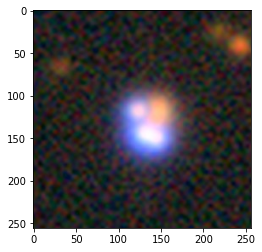

In [35]:
g2 = '/home/verlon/Desktop/Astronomaly/Data/Input/Known Lenses/cutout g2.jpg'

imgplot = plt.imshow(mpimg.imread(g2))
plt.show()

Percentile is : 90
Parameters are : (133.36712646484375, 126.54386901855469, 26.761005401611328, 38.88575744628906, 172.19863891601562)


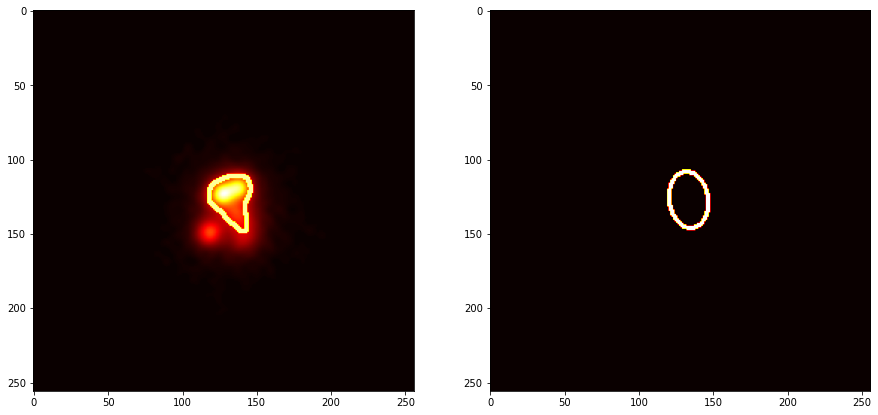

Percentile is : 80
Parameters are : (131.9990692138672, 133.84320068359375, 40.974056243896484, 53.884578704833984, 10.991537094116211)


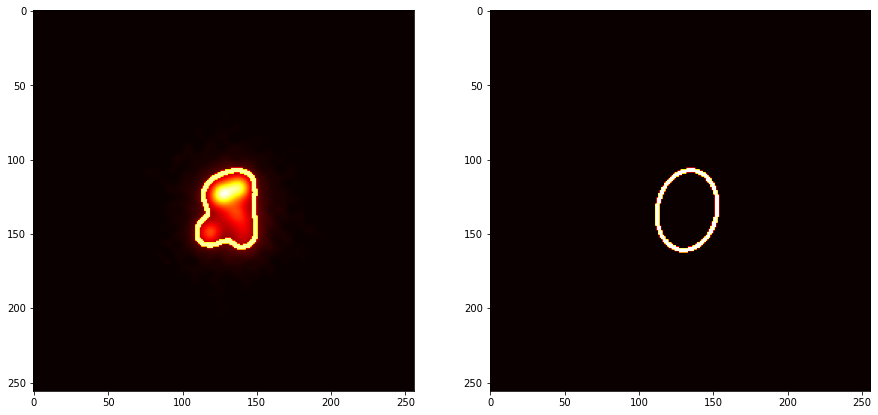

Percentile is : 70
Parameters are : (132.0250701904297, 134.9410400390625, 49.63589096069336, 63.98283386230469, 7.732471466064453)


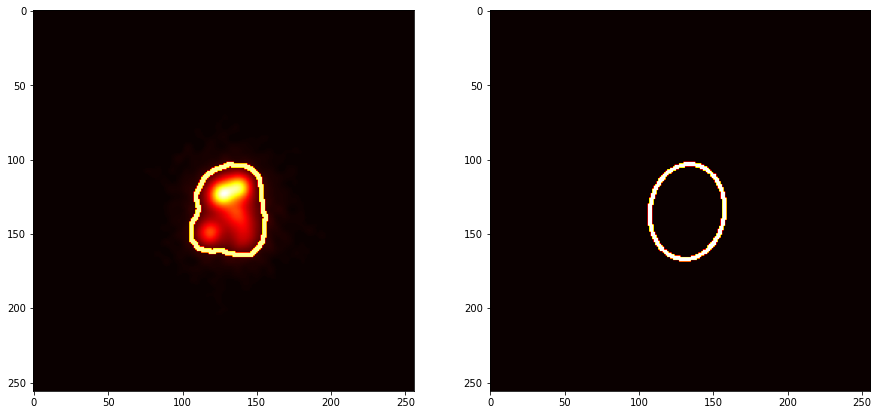

Percentile is : 60
Parameters are : (131.79103088378906, 135.96827697753906, 58.768585205078125, 72.95149230957031, 6.429067134857178)


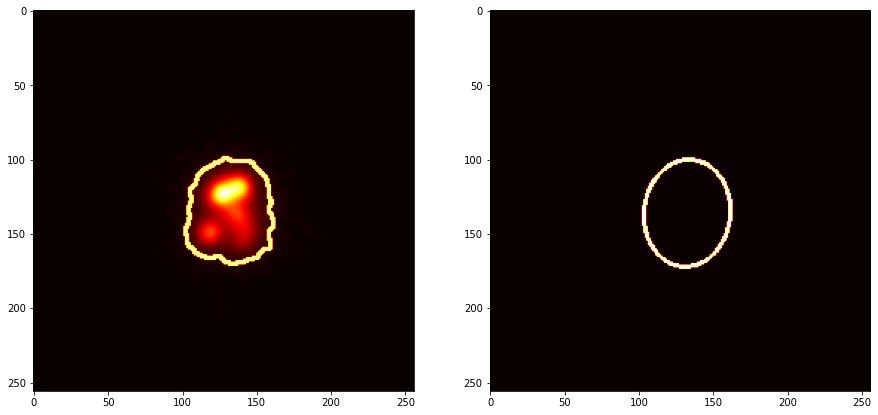

Percentile is : 50
Parameters are : (131.96151733398438, 135.33718872070312, 69.0253677368164, 78.25468444824219, 2.8038275241851807)


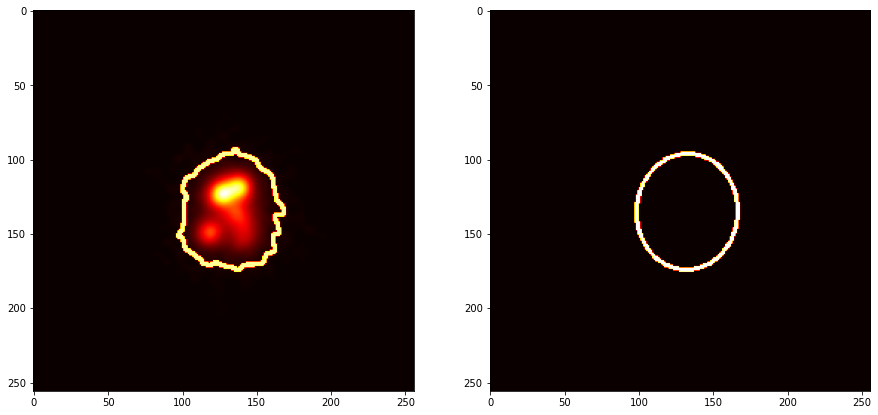

Percentile is : 0
Parameters are : (132.74496459960938, 135.95640563964844, 102.18800354003906, 114.78240203857422, 164.40208435058594)


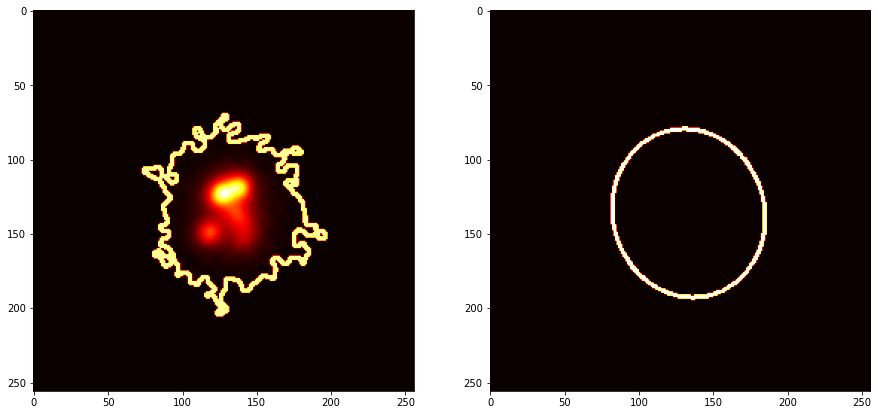

In [36]:
image_g2 = '/home/verlon/Desktop/Astronomaly/Data/Input/Known Lenses/cutout_38.1383_-21.2906.fits'

image_g2_data = fits.getdata(image_g2)

image_g2_data_g = image_g2_data[0]
image_g2_data_r = image_g2_data[1]
image_g2_data_z = image_g2_data[2]

contours_and_ellipses(image_g2_data_z, percentiles)

#### Image 3

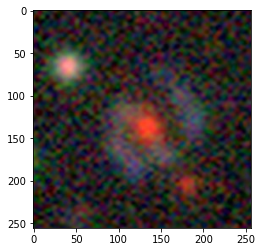

In [37]:
g3 = '/home/verlon/Desktop/Astronomaly/Data/Input/Known Lenses/cutout g3.jpg'

imgplot = plt.imshow(mpimg.imread(g3))
plt.show()

Percentile is : 90
Parameters are : (119.01470184326172, 115.47733306884766, 77.82891082763672, 90.84052276611328, 30.14103126525879)


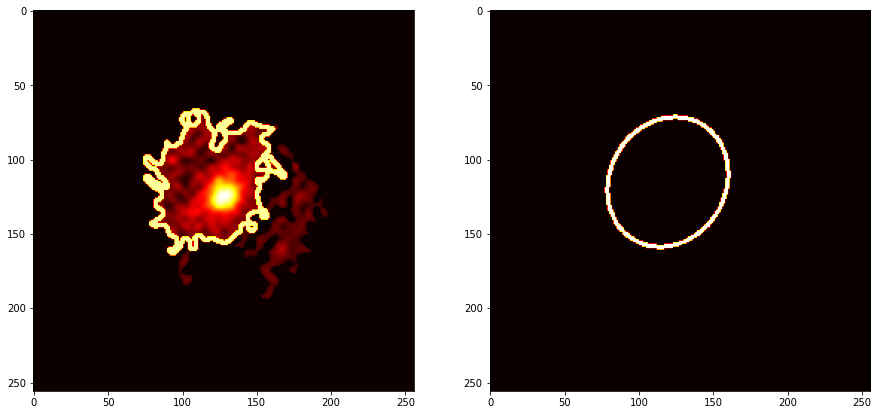

Percentile is : 80
Parameters are : (131.47171020507812, 125.97823333740234, 100.80432891845703, 115.09011840820312, 145.1705780029297)


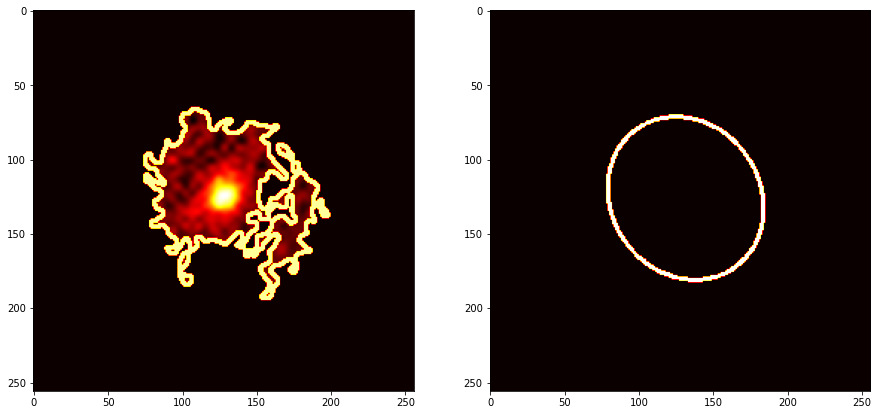

Percentile is : 70
Parameters are : (131.47171020507812, 125.97823333740234, 100.80432891845703, 115.09011840820312, 145.1705780029297)


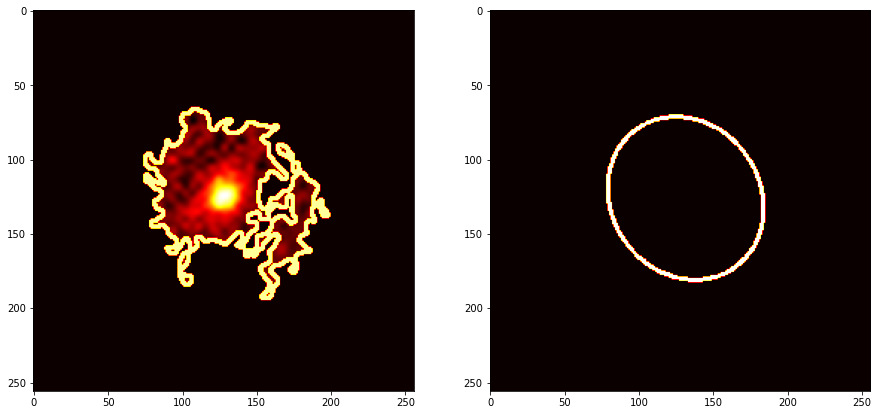

Percentile is : 60
Parameters are : (131.47171020507812, 125.97823333740234, 100.80432891845703, 115.09011840820312, 145.1705780029297)


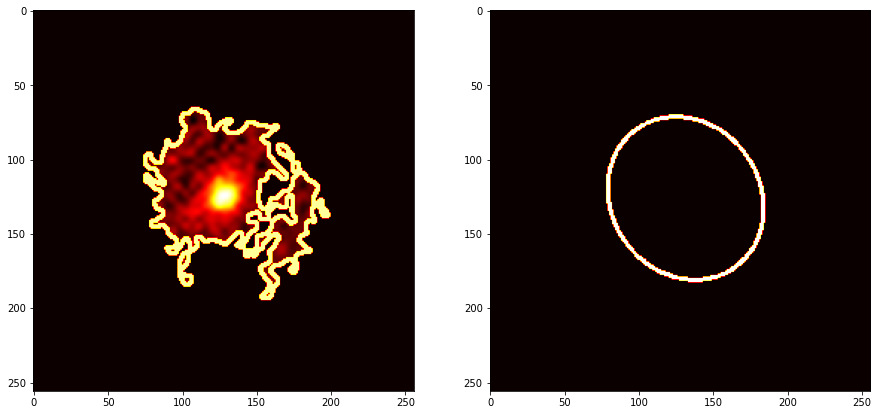

Percentile is : 50
Parameters are : (131.47171020507812, 125.97823333740234, 100.80432891845703, 115.09011840820312, 145.1705780029297)


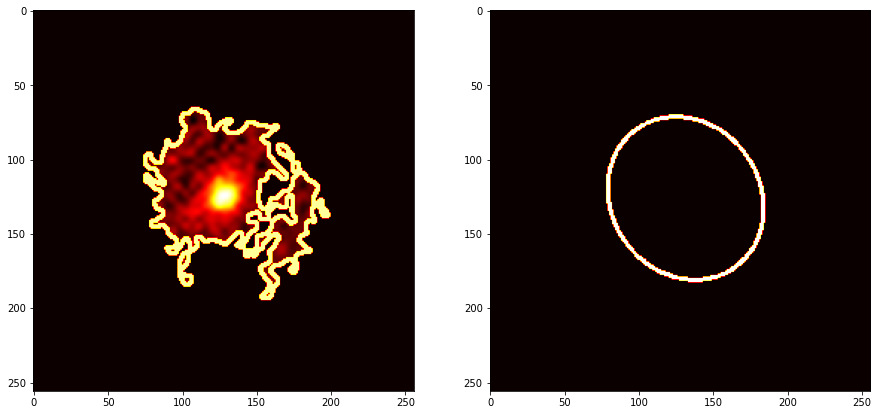

Percentile is : 0
Parameters are : (131.47171020507812, 125.97823333740234, 100.80432891845703, 115.09011840820312, 145.1705780029297)


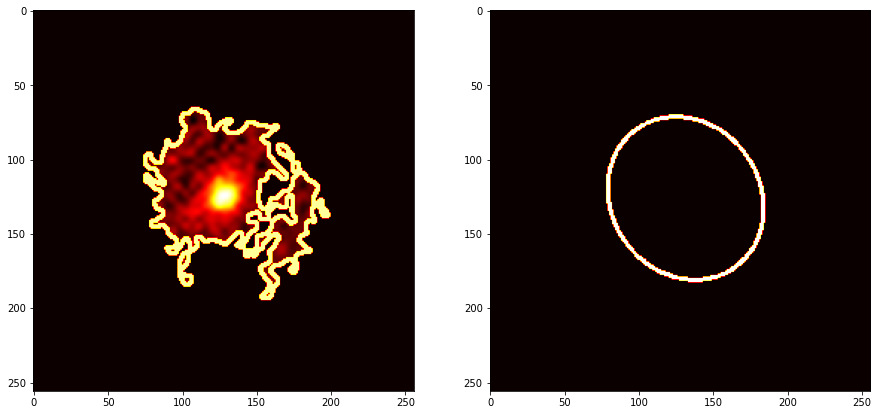

In [38]:
image_g3 = '/home/verlon/Desktop/Astronomaly/Data/Input/Known Lenses/cutout_133.5531_-4.4025.fits'

image_g3_data = fits.getdata(image_g3)

image_g3_data_g = image_g3_data[0]
image_g3_data_r = image_g3_data[1]
image_g3_data_z = image_g3_data[2]

contours_and_ellipses(image_g3_data_z, percentiles)

#### Image 4

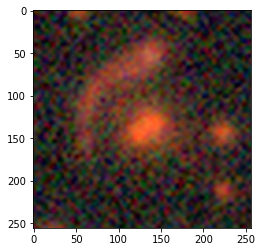

In [39]:
g4 = '/home/verlon/Desktop/Astronomaly/Data/Input/Known Lenses/cutout g4.jpg'

imgplot = plt.imshow(mpimg.imread(g4))
plt.show()

Percentile is : 90
Parameters are : (139.50616455078125, 117.47342681884766, 32.71144485473633, 42.21086883544922, 123.34685516357422)


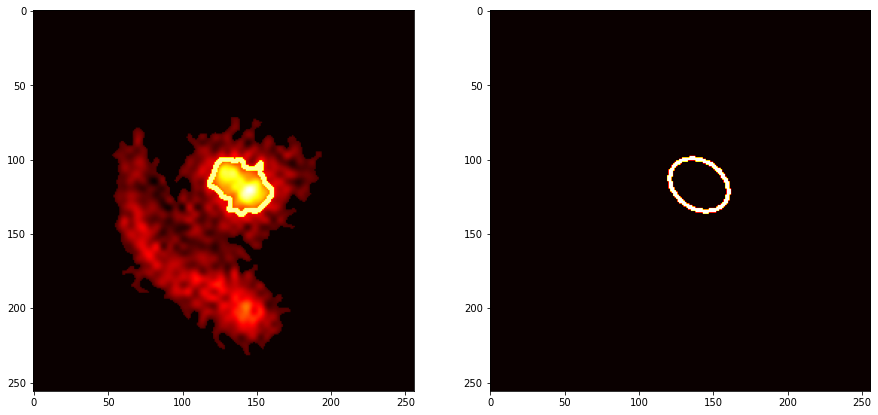

Percentile is : 80
Parameters are : (139.01759338378906, 117.27245330810547, 39.83294677734375, 50.21549606323242, 121.26353454589844)


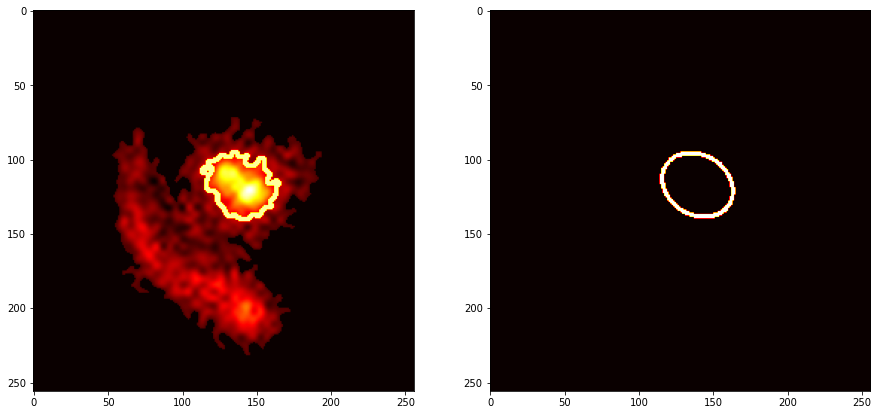

Percentile is : 70
Parameters are : (140.51437377929688, 117.62619018554688, 43.58439254760742, 56.81218719482422, 112.51181030273438)


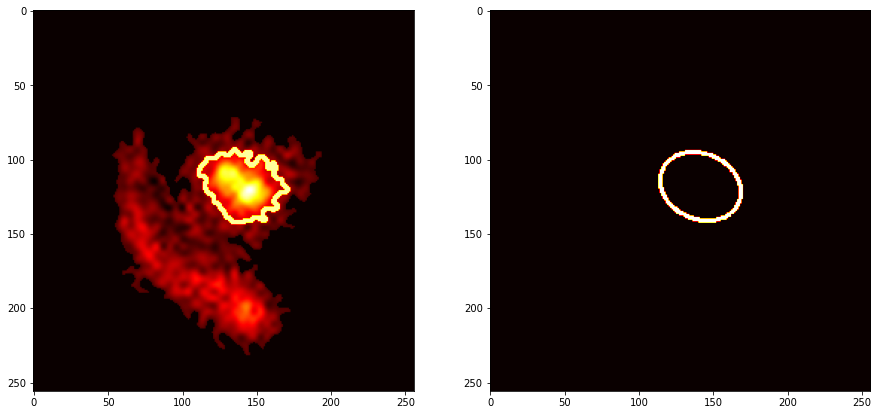

Percentile is : 60
Parameters are : (138.99806213378906, 118.22026824951172, 49.02771759033203, 61.8064079284668, 114.77278137207031)


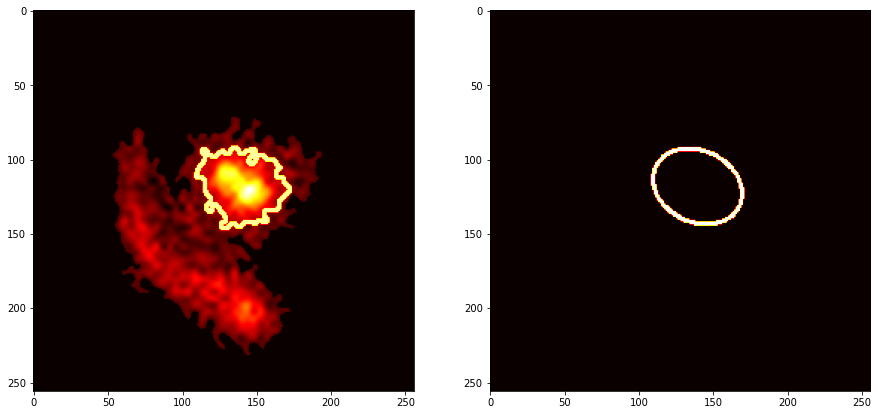

Percentile is : 50
Parameters are : (140.79049682617188, 117.94380950927734, 56.37101364135742, 64.93280029296875, 113.4285659790039)


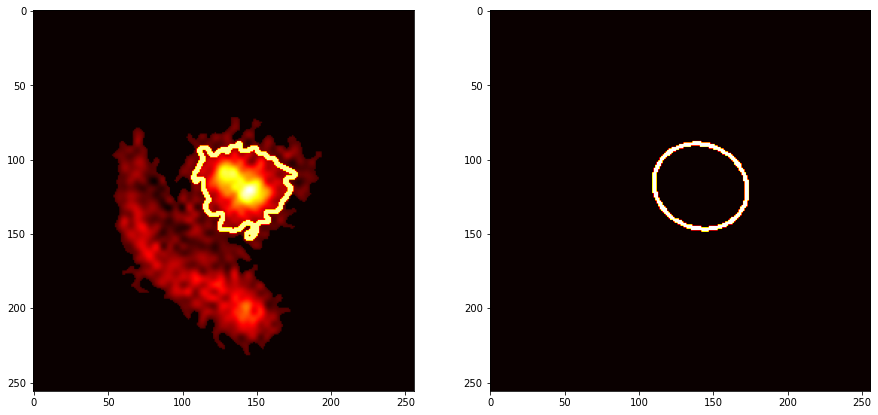

Percentile is : 0
Parameters are : (122.41252136230469, 144.93714904785156, 129.64210510253906, 145.37596130371094, 179.4942626953125)


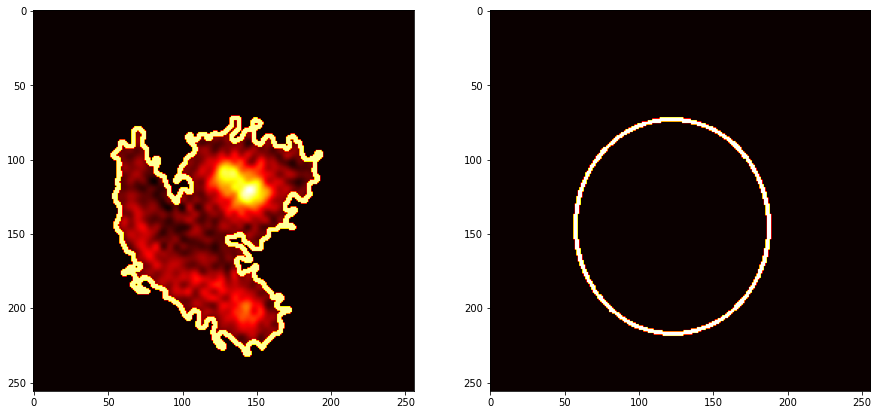

In [40]:
image_g4 = '/home/verlon/Desktop/Astronomaly/Data/Input/Known Lenses/cutout_155.7368_-5.0528.fits'

image_g4_data = fits.getdata(image_g4)

image_g4_data_g = image_g4_data[0]
image_g4_data_r = image_g4_data[1]
image_g4_data_z = image_g4_data[2]

contours_and_ellipses(image_g4_data_z, percentiles)